<a href="https://colab.research.google.com/github/abhaygoel/AIML/blob/master/Capstone_Project_CV_Abhay_EDA_Resnet_CheXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

#os.chdir("/content/drive/My Drive/Colab Notebooks/Capstone Project/data")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import zipfile, tqdm
# with zipfile.ZipFile('rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
#     zip_ref.extractall('unzip')
# Copy Unzipped files to Colab for faster access
# https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

%%time
# os.chdir('/')
zip_path='/content/drive/My Drive/Colab Notebooks/Capstone Project/data/rsna-pneumonia-detection-challenge.zip'
!cp "{zip_path}" .
!unzip -q rsna-pneumonia-detection-challenge.zip
!rm rsna-pneumonia-detection-challenge.zip
!cd ~
!pwd
!ls -al 


/content
total 5388
drwxr-xr-x 1 root root    4096 Sep 20 05:23  .
drwxr-xr-x 1 root root    4096 Sep 20 02:46  ..
drwxr-xr-x 1 root root    4096 Sep 16 16:29  .config
drwxr-xr-x 4 root root    4096 Sep 20 02:59  content
drwx------ 4 root root    4096 Sep 20 02:51  drive
-rw-r--r-- 1 root root      55 Dec 11  2019 'GCP Credits Request Link - RSNA.txt'
drwxr-xr-x 1 root root    4096 Sep 16 16:29  sample_data
-rw-r--r-- 1 root root 1647396 Dec 11  2019  stage_2_detailed_class_info.csv
-rw-r--r-- 1 root root  159027 Dec 11  2019  stage_2_sample_submission.csv
drwxr-xr-x 2 root root  229376 Sep 20 05:23  stage_2_test_images
drwxr-xr-x 2 root root 1953792 Sep 20 05:23  stage_2_train_images
-rw-r--r-- 1 root root 1490034 Dec 11  2019  stage_2_train_labels.csv
CPU times: user 285 ms, sys: 328 ms, total: 614 ms
Wall time: 2min 19s


In [ ]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 98kB/s 


In [ ]:
import pydicom
import os
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt
import cv2
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Lets figure what information/metadata does the dcm file contain
#dataset = pydicom.dcmread('unzip/stage_2_train_images/0a0f6755-610d-4b7c-a460-5f5a8f5c0743.dcm')
dataset = pydicom.dcmread('stage_2_train_images/0a0f6755-610d-4b7c-a460-5f5a8f5c0743.dcm')
print('Dataset content:')
print(dataset)

In [ ]:
# Define a function to view some interesting metadata fields, 
# this is taken almost directly from the pydicom website

def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        # print("img_mean:",np.mean(dataset.pixel_array))
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

In [ ]:
# Function to plot images
def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Lets try to visualize some images and metadata in dcm files.

In [ ]:
#data_path = 'unzip/stage_2_train_images'
data_path = 'stage_2_train_images'

i = 1
num_to_plot = 5
for file_name in os.listdir(data_path):
    file_path = os.path.join(data_path, file_name)
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    
    if i >= num_to_plot:
        break
    
    i += 1

**Read dcm metadata into a Dataframe for EDA**

In [ ]:
from tqdm import tqdm
####################################
##### ONLY FOR UNZIPPING TEST IMAGES
data_path = 'stage_2_test_images'
####################################
train_df = pd.DataFrame()
ids = []
ages = []
sexs = []
modalities = []
examinedBodyParts = []
viewPositions = []
# img_mean = []
# img_min = []
# img_max = []
 
# Iterate over 
for file_name in tqdm(os.listdir(data_path)):
    file_path = os.path.join(data_path, file_name)
    dataset = pydicom.dcmread(file_path)
    ids.append(dataset.PatientID)
    ages.append(dataset.PatientAge)
    sexs.append(dataset.PatientSex)
    modalities.append(dataset.Modality)
    examinedBodyParts.append(dataset.BodyPartExamined)
    viewPositions.append(dataset.ViewPosition)
    # img_mean.append(dataset.pixel_array.mean())
    # img_min.append(dataset.pixel_array.min())
    # img_max.append(dataset.pixel_array.max())


train_df['patientId'] = pd.Series(ids)
train_df['patientAge'] = pd.Series(ages, dtype='int')
train_df['patientSex'] = pd.Series(sexs)
train_df['patientModality'] = pd.Series(modalities)
train_df['examinedBodyPart'] = pd.Series(examinedBodyParts)
train_df['viewPosition'] = pd.Series(viewPositions)
# train_df['imgMin'] = pd.Series(img_min )
# train_df['imgMax'] = pd.Series(img_max )
# train_df['imgMean'] = pd.Series(img_mean )

100%|██████████| 26684/26684 [05:05<00:00, 87.32it/s]
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:

# See what the data looks like
print(train_df.shape)
train_df.head(20)


(26684, 9)


patientId  patientAge  ... imgMax     imgMean
0   52c13b33-0eb6-4d1e-932a-0b0fb56e391a          63  ...    255  127.645963
1   c7bd1ae2-02fd-4a33-9d4c-34b156f83fe6          68  ...    249  151.750391
2   56265d5f-bd30-46cd-84b8-023d6053df4e          57  ...    231  132.811038
3   997ffa12-415b-4573-b3ad-b40db604668b          55  ...    255  162.062301
4   9f10dd1b-c139-44cf-bce0-c6199f4c6e13          53  ...    225  113.900095
5   44807d59-cd8d-480f-9562-6cca6205ee94          68  ...    248  129.591327
6   fa252d6a-dfcf-41bb-8089-6fe5cd196abf          65  ...    245  130.251064
7   3ca6661a-ffbd-4d4d-b49b-c96cfd218307          42  ...    236  137.278691
8   d4aef316-354b-485e-8ce8-23d4bef88d80          65  ...    246  110.201934
9   68c02c6c-8426-4a07-ab77-7217078a6e6a          60  ...    255  124.969313
10  b74815e5-66c4-40fa-ad4a-e85526b278d5          26  ...    255  123.277596
11  934874fc-846f-4e62-a044-4e2d4dad4fad          52  ...    244  117.398835
12  f2ca38b7-7222-4f3e-819d-c3c3713d9238          20  ...    255  165.971493
13  4a2abe71-8cd4-4d57-978d-2da7d67bd80d           4  ...    255   47.449142
14  ba2fad3a-ac70-4be3-a7dd-c092f1dfdaf6          27  ...    255  128.063196
15  4f91160b-f1f5-4b70-86c0-f820f7d6aec2          64  ...    240  114.010392
16  62e7f210-65e0-40e1-ba52-8c21b6e767e9          25  ...    239  137.871970
17  46a46b58-a96b-438b-9742-ade04045c9fb          36  ...    249  106.720243
18  c95a1770-d740-4f50-b4a6-8e4a53ff9767          55  ...    255  108.295674
19  345e6018-89b7-41d0-bd33-2350c1c60311          47  ...    255  111.403285

[20 rows x 9 columns]

In [ ]:
# Print highlevel stats on this data
train_df.describe().T

count        mean        std  ...         50%         75%         max
patientAge  26684.0   47.030018  16.810578  ...   49.000000   59.000000  155.000000
imgMin      26684.0    0.379928   2.169367  ...    0.000000    0.000000   95.000000
imgMax      26684.0  247.998014  14.061758  ...  255.000000  255.000000  255.000000
imgMean     26684.0  124.978564  21.608709  ...  120.337328  137.178996  229.147834

[4 rows x 8 columns]

**We see max age of 155. This does not look practical. We'll explore other outliers further down the line.**

**Add class details from csv to the dataframe for a consolidated EDA.**

In [ ]:
# Adding Class details
#class_df = pd.read_csv('unzip/stage_2_detailed_class_info.csv')
class_df = pd.read_csv('stage_2_detailed_class_info.csv')

# class csv has duplicates
dups = class_df[class_df.duplicated()]
dups


patientId         class
5      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9      00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
15     00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity
17     00c0b293-48e7-4e16-ac76-9269ba535a62  Lung Opacity
20     00f08de1-517e-4652-a04f-d1dc9ee48593  Lung Opacity
...                                     ...           ...
30209  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  Lung Opacity
30215  c1cddf32-b957-4753-acaa-472ab1447e86  Lung Opacity
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  Lung Opacity
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

[3543 rows x 2 columns]

In [ ]:
# Remove duplicates
class_df.drop_duplicates(subset ="patientId", keep = 'first', inplace = True)

In [ ]:
df = class_df.groupby('class')['patientId'].nunique()
df

class
Lung Opacity                     6012
No Lung Opacity / Not Normal    11821
Normal                           8851
Name: patientId, dtype: int64

In [ ]:
train_df = pd.merge(left=train_df, right=class_df, left_on='patientId', right_on='patientId')
train_df.head(10)

patientId  ...                         class
0  52c13b33-0eb6-4d1e-932a-0b0fb56e391a  ...                        Normal
1  c7bd1ae2-02fd-4a33-9d4c-34b156f83fe6  ...                        Normal
2  56265d5f-bd30-46cd-84b8-023d6053df4e  ...  No Lung Opacity / Not Normal
3  997ffa12-415b-4573-b3ad-b40db604668b  ...  No Lung Opacity / Not Normal
4  9f10dd1b-c139-44cf-bce0-c6199f4c6e13  ...  No Lung Opacity / Not Normal
5  44807d59-cd8d-480f-9562-6cca6205ee94  ...  No Lung Opacity / Not Normal
6  fa252d6a-dfcf-41bb-8089-6fe5cd196abf  ...  No Lung Opacity / Not Normal
7  3ca6661a-ffbd-4d4d-b49b-c96cfd218307  ...                  Lung Opacity
8  d4aef316-354b-485e-8ce8-23d4bef88d80  ...  No Lung Opacity / Not Normal
9  68c02c6c-8426-4a07-ab77-7217078a6e6a  ...                        Normal

[10 rows x 10 columns]

**Looks like there is some duplicate data (row 3, 4 above). We may have to de-dupe data for better EDA.**

In [ ]:
# Store Dataframe to csv for easy reload
train_df.to_csv('dcm_meta_with_class.csv', index=False)

In [ ]:
# copy it back to gdrive
!cp dcm_meta_with_class.csv '/content/drive/My Drive/Colab Notebooks/Capstone Project/data/unzip/dcm_meta_with_class.csv'

In [ ]:

dups = train_df[train_df.duplicated(['patientId'])]
dups.info

<bound method DataFrame.info of Empty DataFrame
Columns: [patientId, patientAge, patientSex, patientModality, examinedBodyPart, viewPosition, imgMin, imgMax, imgMean, class]
Index: []>

**Initial EDA**


1.   Determine Missing Values
2.   Determine Outliers
3.   Plot distribution
4.   Determine corelation between various attributes



In [ ]:
# Determine Missing Values
train_df.isnull().sum()

patientId           0
patientAge          0
patientSex          0
patientModality     0
examinedBodyPart    0
viewPosition        0
imgMin              0
imgMax              0
imgMean             0
class               0
dtype: int64

**Looks like all attributes have values.**

In [ ]:
# Some stats grouped by class
train_df.groupby(by='class').describe().T

class             Lung Opacity  No Lung Opacity / Not Normal       Normal
patientAge count   6012.000000                  11821.000000  8851.000000
           mean      45.582502                     49.333305    44.937069
           std       17.468836                     16.490855    16.390951
           min        1.000000                      1.000000     2.000000
           25%       32.000000                     38.000000    33.000000
           50%       47.000000                     52.000000    46.000000
           75%       58.000000                     61.000000    57.000000
           max       92.000000                    153.000000   155.000000
imgMin     count   6012.000000                  11821.000000  8851.000000
           mean       0.311377                      0.386346     0.417919
           std        1.784473                      2.362936     2.136450
           min        0.000000                      0.000000     0.000000
           25%        0.000000                      0.000000     0.000000
           50%        0.000000                      0.000000     0.000000
           75%        0.000000                      0.000000     0.000000
           max       54.000000                     95.000000    40.000000
imgMax     count   6012.000000                  11821.000000  8851.000000
           mean     247.933799                    248.048304   247.974466
           std       13.121038                     13.846620    14.938489
           min      147.000000                    146.000000   149.000000
           25%      245.000000                    246.000000   246.000000
           50%      255.000000                    255.000000   255.000000
           75%      255.000000                    255.000000   255.000000
           max      255.000000                    255.000000   255.000000
imgMean    count   6012.000000                  11821.000000  8851.000000
           mean     122.295715                    124.991768   126.783243
           std       21.432094                     21.207641    22.067919
           min       32.196316                     37.506790    26.417231
           25%      109.356102                    110.676870   110.995566
           50%      117.651767                    120.343489   122.403131
           75%      134.604264                    136.872555   139.387740
           max      229.147834                    200.543401   196.763203

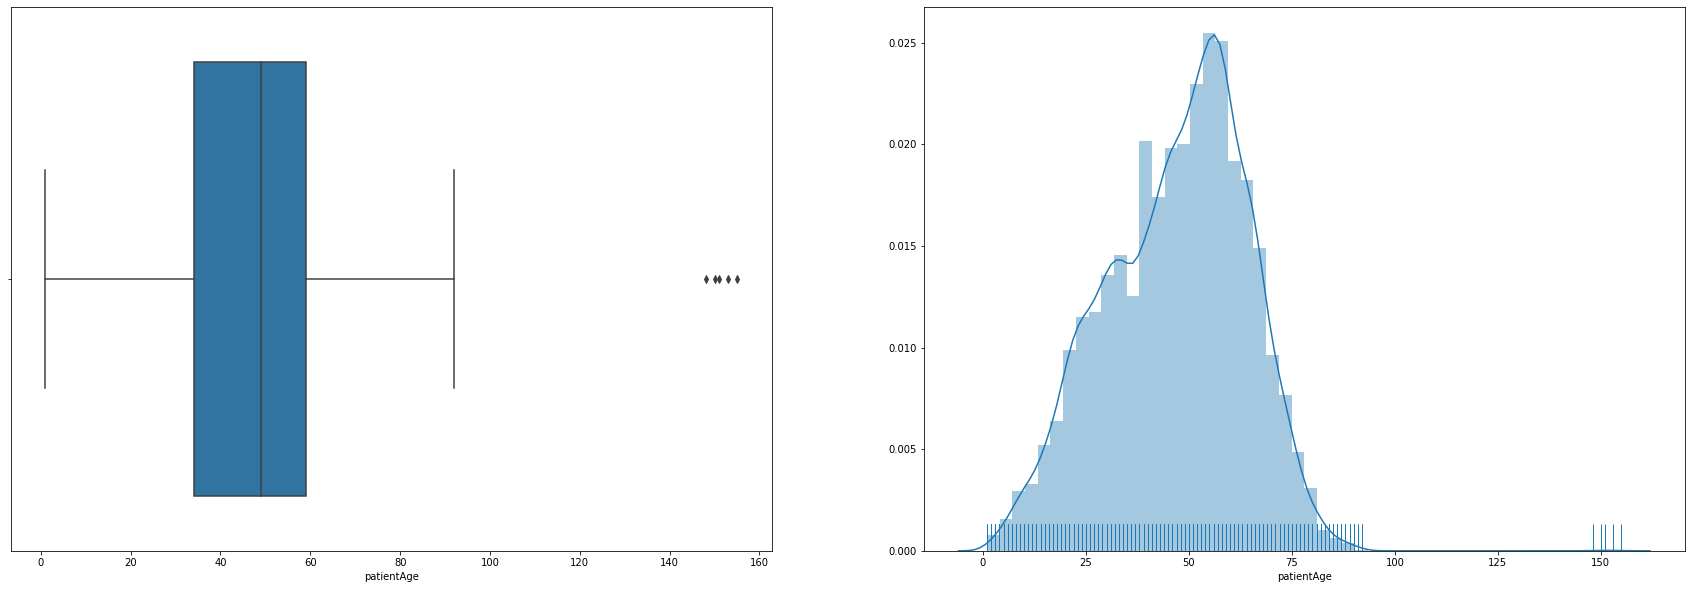

In [ ]:
fig, ax_arr = plt.subplots(1,2, figsize = (30,10))
sns.boxplot(x=train_df['patientAge'], ax = ax_arr[0])
sns.distplot(train_df.patientAge, ax = ax_arr[1], rug=True)

**From the frequency distribution above, it appears that age is skewed towards higher values with most patients age being >50. Outliers lie between 140 and 160 (closer to 150). It could mean a typo or the age is in months. We will further explore this attribute.**

In [ ]:
# Lets view images for these outliers. 
# If the age is in months (children or early tenn), the image should  show relatively smaller structure.
print("Number of Patients aged above 100:",train_df[train_df['patientAge'] > 100]['patientAge'].count())

# getting the customer ID with negative experience
outlier_id_list = train_df.loc[train_df.patientAge>100]['patientId'].tolist()
outlier_id_list

Number of Patients aged above 100: 5


['ec3697bd-184e-44ba-9688-ff8d5fbf9bbc',
 '3b8b8777-a1f6-4384-872a-28b95f59bf0d',
 'a4e8e96d-93a6-4251-b617-91382e610fab',
 'f632328d-5819-4b29-b54f-adf4934bbee6',
 '73aeea88-fc48-4030-8564-0a9d7fdecac4']

In [ ]:
# Create a function to display images for a given list of patientIds.
def plot_img_for_ids(ids):
    for file_name in ids:
      file_path = os.path.join(data_path, file_name + ".dcm")
      dataset = pydicom.dcmread(file_path)
      plot_pixel_array(dataset)  

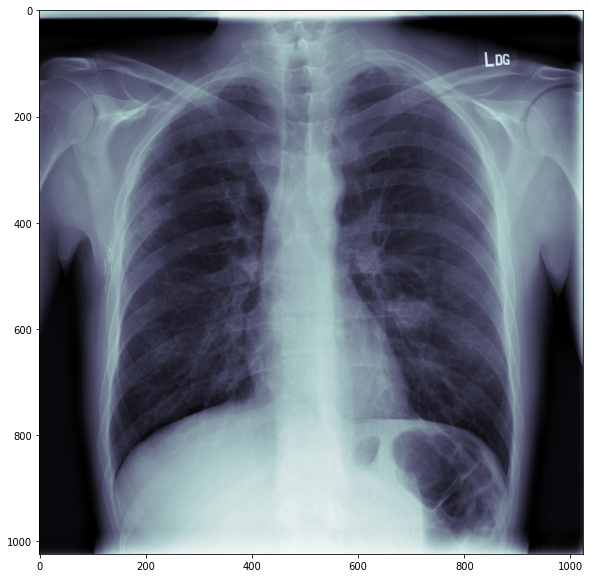

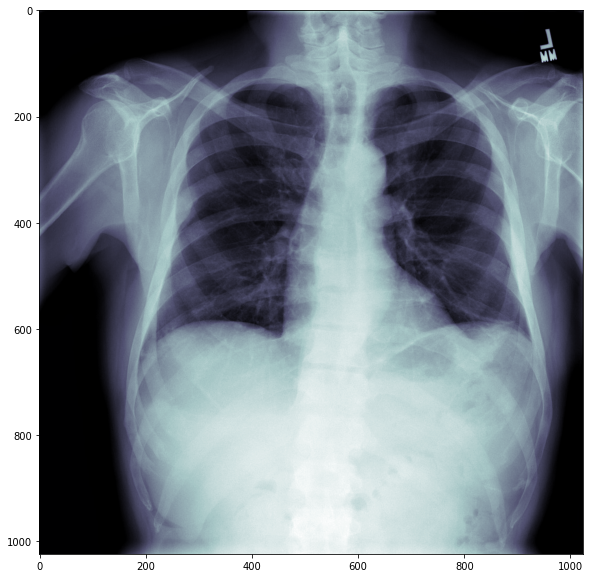

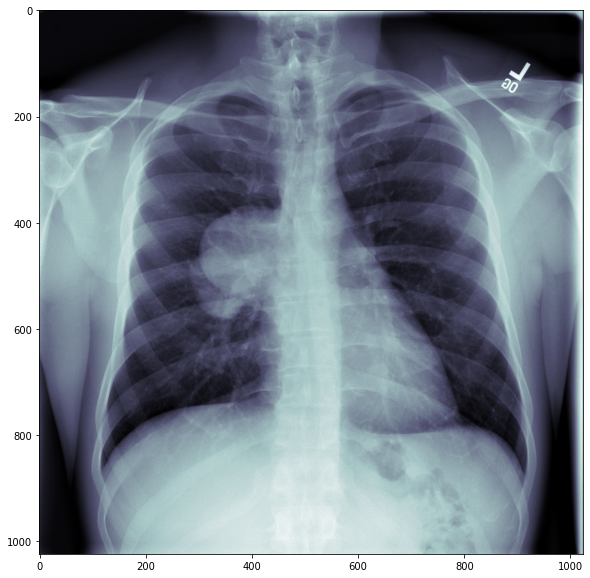

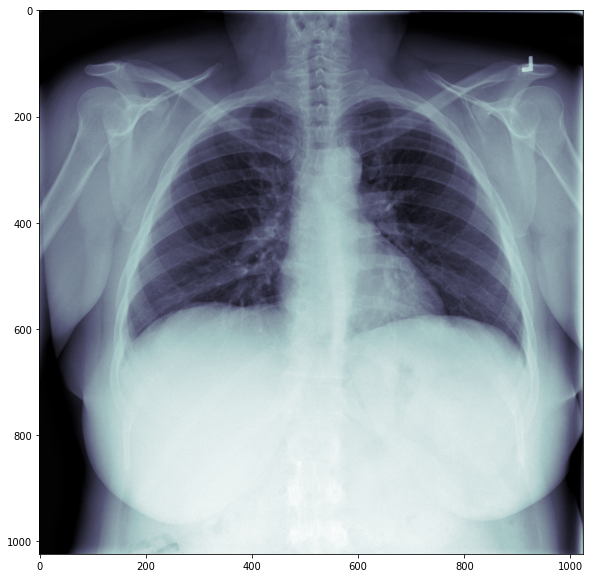

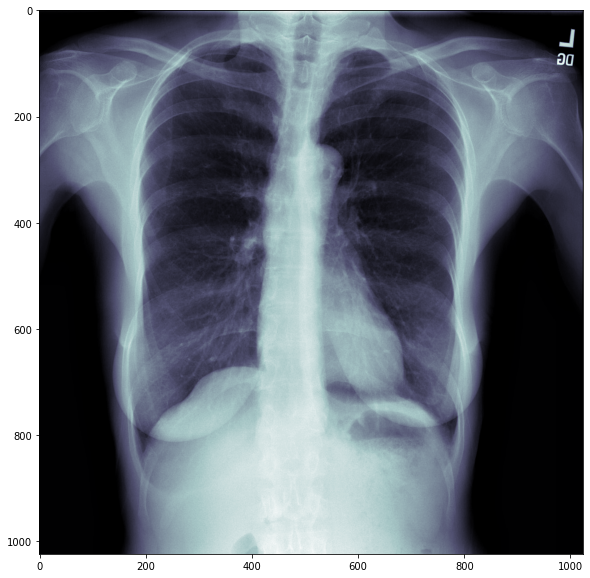

In [ ]:
# Plot Images for Outliers
plot_img_for_ids(outlier_id_list)

**Comparing above images with other data, its unlikely that the**

In [ ]:
# Print images for children <12 years of age
children_id_list = train_df.loc[train_df.patientAge<12]['patientId'].tolist()
children_id_list

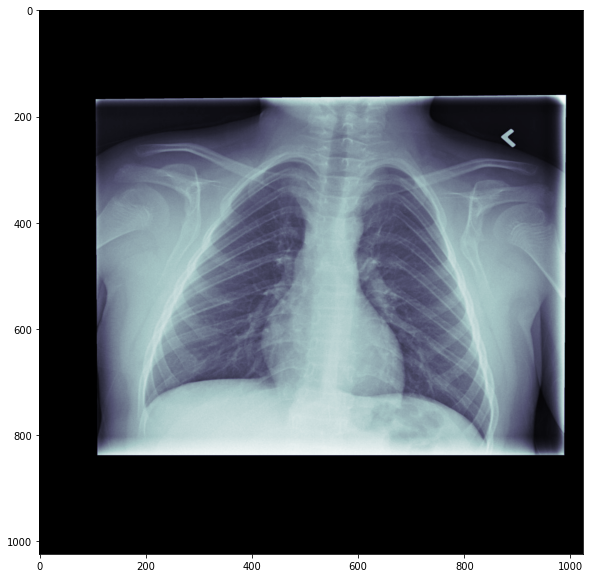

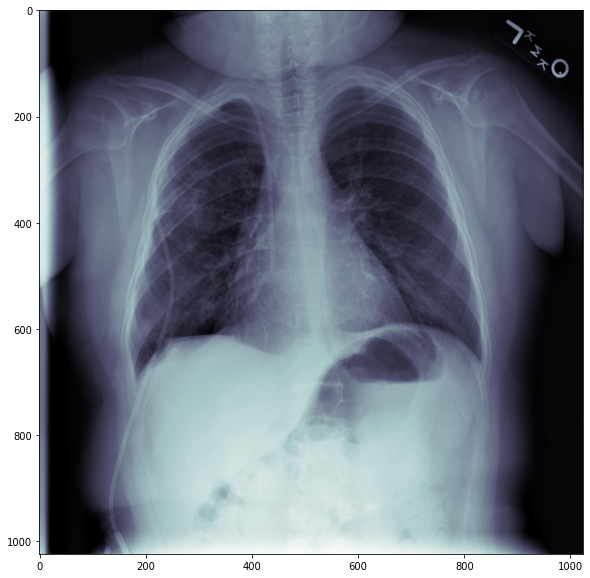

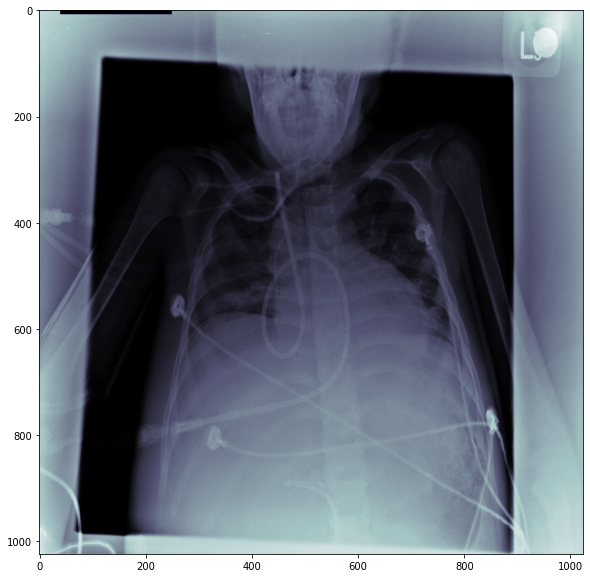

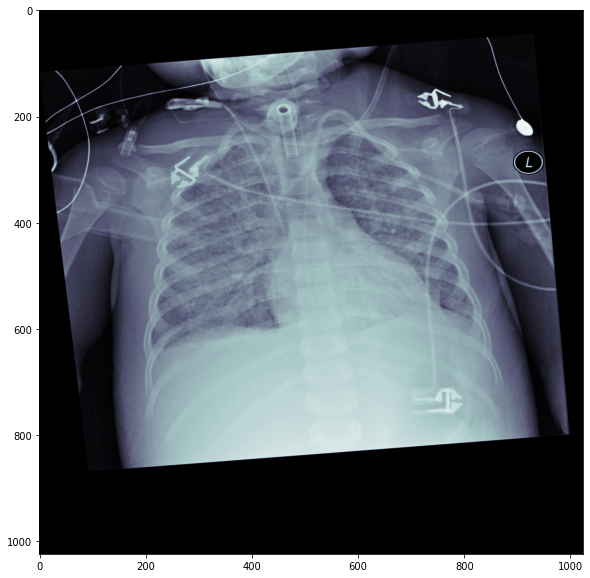

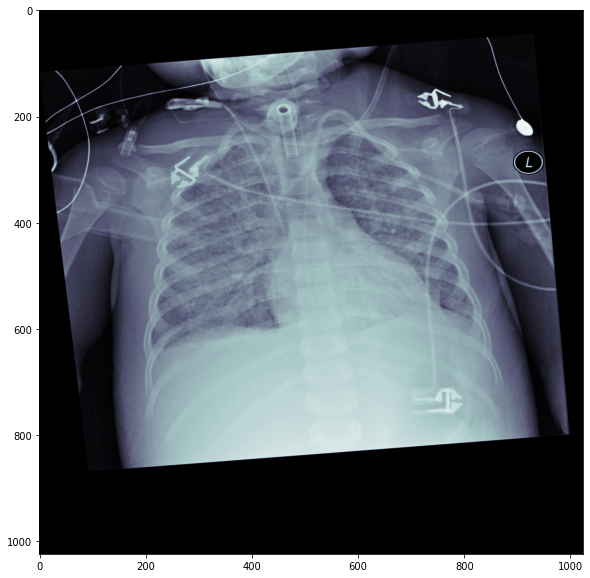

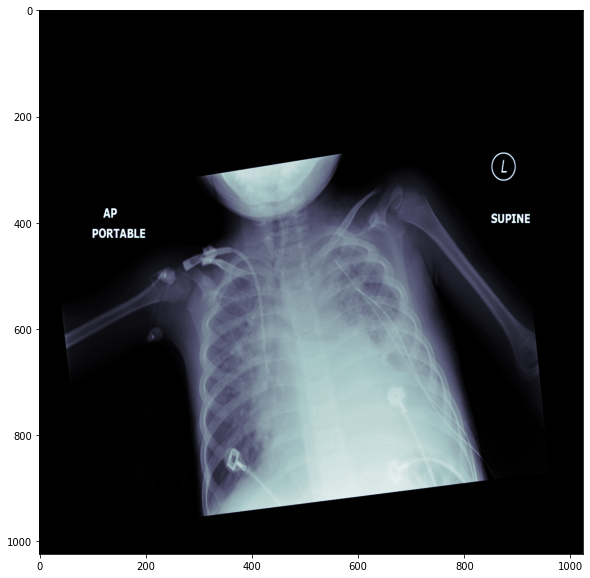

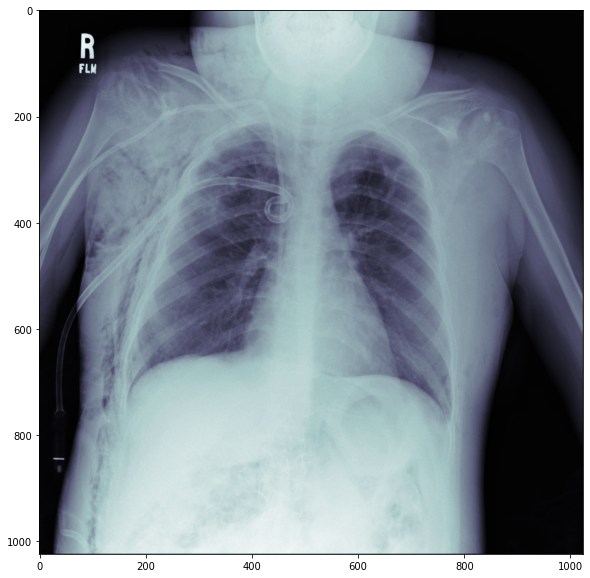

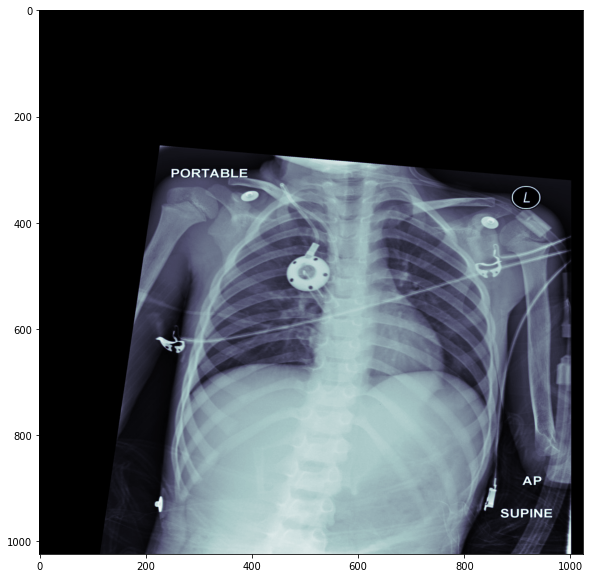

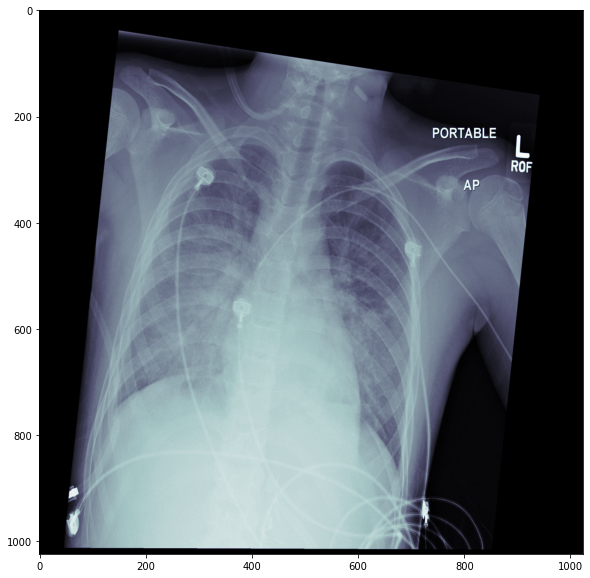

In [ ]:
# There are quite a few images for children. Lets print a few and compare.
plot_img_for_ids(children_id_list[1:10])

**From the above sample it is clear that images for kids are visibly smaller. So the age >100 is mostly a typo. Lets see other data attributes to determine what to do with these outliers.**

In [ ]:
outlier_df = train_df[train_df['patientAge']>100]
outlier_df.head()

patientId  ...                         class
1102   ec3697bd-184e-44ba-9688-ff8d5fbf9bbc  ...                        Normal
1792   3b8b8777-a1f6-4384-872a-28b95f59bf0d  ...                        Normal
1893   a4e8e96d-93a6-4251-b617-91382e610fab  ...  No Lung Opacity / Not Normal
23821  f632328d-5819-4b29-b54f-adf4934bbee6  ...                        Normal
26111  73aeea88-fc48-4030-8564-0a9d7fdecac4  ...  No Lung Opacity / Not Normal

[5 rows x 7 columns]

**All the age outliers belong to a class that do not have lung opacity ie. no pneumonia(single class for our purpose).**

**Lets see the distribution of target class to determine if we can safely ignore these outliers.**

In [ ]:

train_df['class'].unique()

array(['Normal', 'No Lung Opacity / Not Normal', 'Lung Opacity'],
      dtype=object)

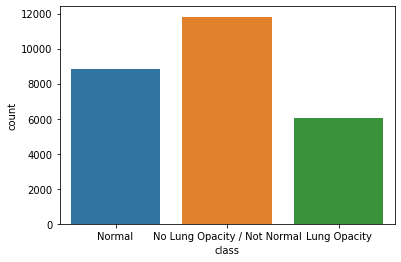

In [ ]:
# Distribution of class
sns.countplot(x="class", data=train_df)

**Considering the above countplot, it is clear that the count of  class with Lung Opacity is less than half of the total count. Removing this data should not have much impact.**

Text(0.5, 1.0, ' Age Distribution for class=Lung Opacity')

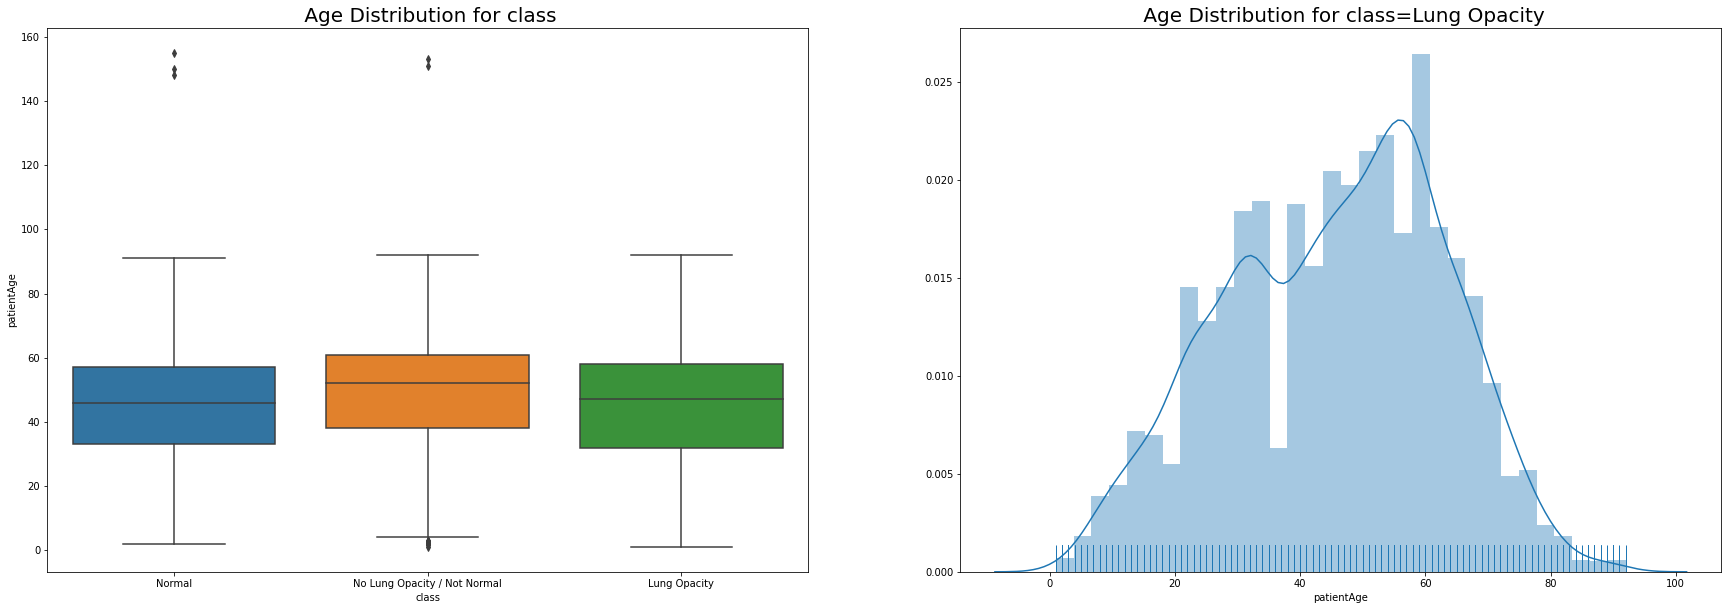

In [ ]:
fig, ax_arr = plt.subplots(1,2, figsize = (30,10))
sns.boxplot(x='class',y='patientAge',data=train_df, ax = ax_arr[0])
ax_arr[0].set_title(' Age Distribution for class', fontsize=20)
# Frequency distribution
sns.distplot(train_df[train_df['class']=='Lung Opacity'].patientAge, ax = ax_arr[1], rug=True)
ax_arr[1].set_title(' Age Distribution for class=Lung Opacity', fontsize=20)



In [ ]:
# look at age statistics between positive and negative target groups
train_df.drop_duplicates('patientId').groupby('class')['patientAge'].describe()

count       mean        std  ...   50%   75%    max
class                                                        ...                   
Lung Opacity                   6012.0  45.582502  17.468836  ...  47.0  58.0   92.0
No Lung Opacity / Not Normal  11821.0  49.333305  16.490855  ...  52.0  61.0  153.0
Normal                         8851.0  44.937069  16.390951  ...  46.0  57.0  155.0

[3 rows x 8 columns]


**From the above it appears that pneumonia is almost normally distributed (mean being  47), with most of the data between ages 40 and 60. Stats show 75% of population with pneumonia is aged 58 or more. Frequency distribution shows a higher percentage of patients with pneumonia between ages 50 and 70. According to the available medical literature, it is found that "people most at risk are infants and young children, adults 65 or older, and people who have other health problems".**



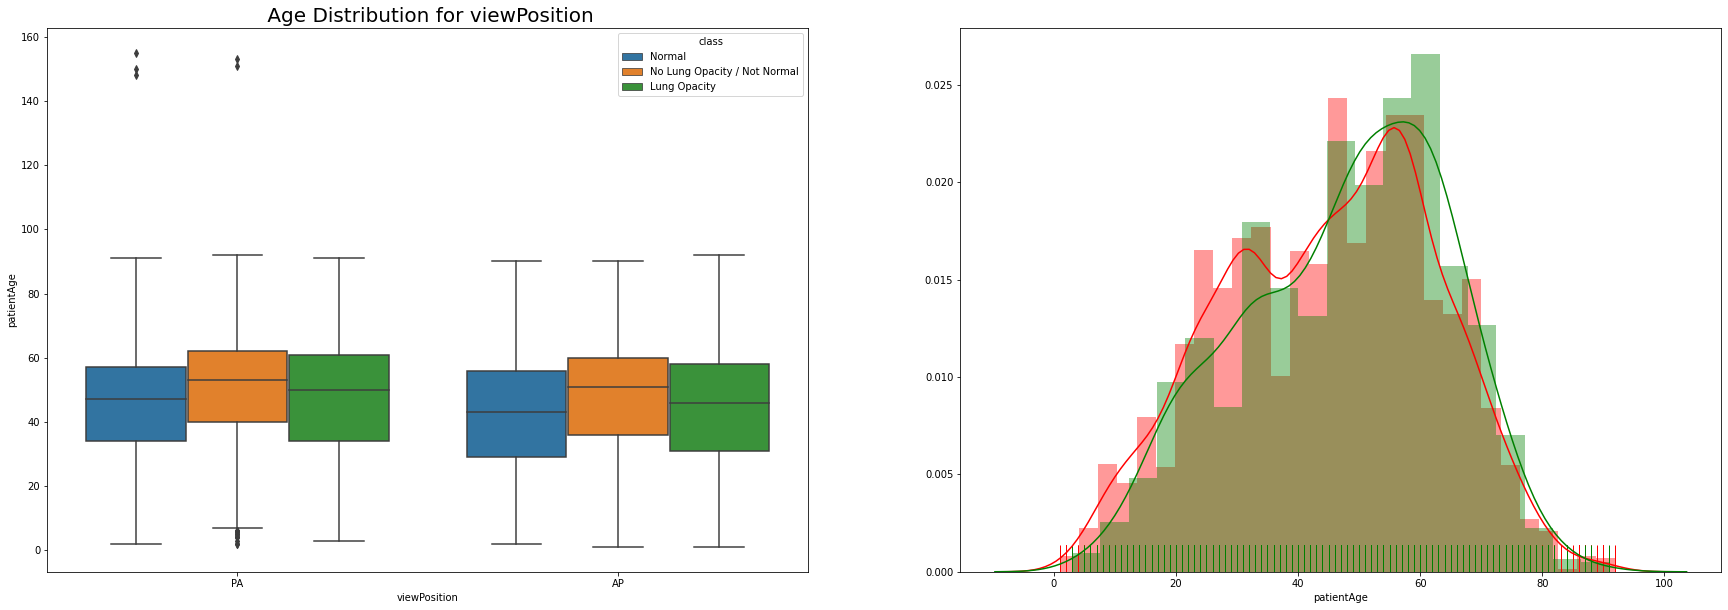

In [ ]:
# Lets look at other attributes - viewPosition with Age.
fig, ax_arr = plt.subplots(1,2, figsize = (30,10))
sns.boxplot(x='viewPosition',y='patientAge',hue='class', data=train_df, ax = ax_arr[0])
ax_arr[0].set_title(' Age Distribution for viewPosition', fontsize=20)
# Frequency distribution
sns.distplot(train_df[(train_df['viewPosition']=='AP') & (train_df['class']=='Lung Opacity')].patientAge, ax = ax_arr[1], color='r', rug=True)
sns.distplot(train_df[(train_df['viewPosition']=='PA') & (train_df['class']=='Lung Opacity')].patientAge, ax = ax_arr[1], color='g', rug=True)

In [ ]:
# look at patient position statistics between positive and negative target groups
train_df.groupby(['viewPosition', 'class']).size() / train_df.groupby(['viewPosition']).size()

viewPosition  class                       
AP            Lung Opacity                    0.383143
              No Lung Opacity / Not Normal    0.482379
              Normal                          0.134478
PA            Lung Opacity                    0.092895
              No Lung Opacity / Not Normal    0.409965
              Normal                          0.497140
dtype: float64

**View Position:**
Normal Posterior to Anterior (PA) Chest X-ray. By convention on the PA View, the x-rays enter the patient posteriorly and exit anteriorly  (with the patients chest on the film cassette), therefore minimizing the cardiac magnification. 

Anterior to Posterior (AP) is normally taken when the patient is unable to stand.

**38% population getting CXR in AP position have Lung Opacity compared to just 9% getting that in PA position.**

**From the above frequency distribution, it appears that higher percentage of patients diagnosed with pneumonia between ages 25 to 35 and between 50 to 60 get CXR in the prone position (AP).**

**Can it be inferred that people in these age ranges get more sick or have 'other problems'?**


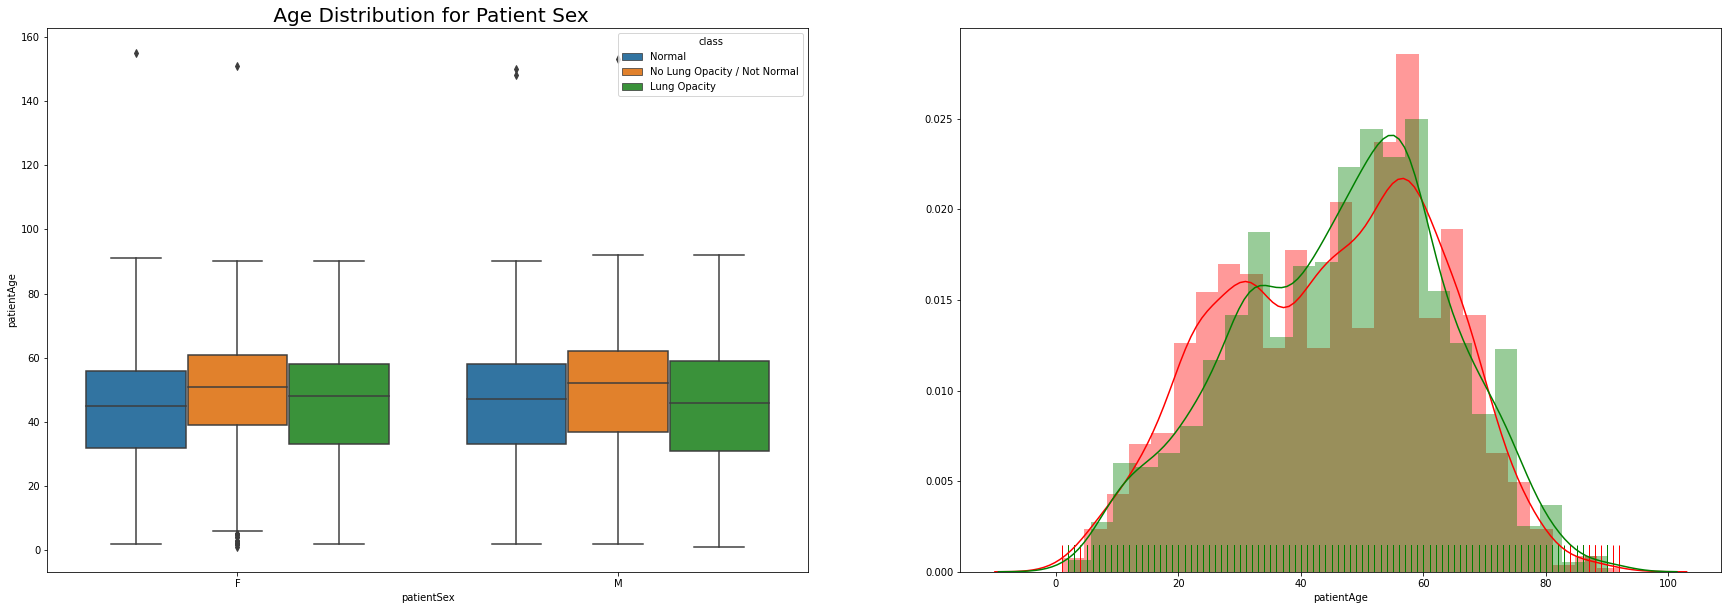

In [ ]:
# Lets look at other attributes - Patient Sex with Age.
fig, ax_arr = plt.subplots(1,2, figsize = (30,10))
sns.boxplot(x='patientSex',y='patientAge',hue='class', data=train_df, ax = ax_arr[0])
ax_arr[0].set_title(' Age Distribution for Patient Sex', fontsize=20)
# Frequency distribution
sns.distplot(train_df[(train_df['patientSex']=='M') & (train_df['class']=='Lung Opacity')].patientAge, ax = ax_arr[1], color='r', rug=True)
sns.distplot(train_df[(train_df['patientSex']=='F') & (train_df['class']=='Lung Opacity')].patientAge, ax = ax_arr[1], color='g', rug=True)

**Frequency distribution shows that a compared to Males, Females > 45 years of age have a higher frequency of pneumonia. Males have a higher frequency at lower age group (15-30).**

In [ ]:
# Check if pixel_array stats have a bearing
# fig, ax_arr = plt.subplots(1,2, figsize = (30,10))
# sns.boxplot(x='imgMean',y='patientAge',hue='class', data=train_df, ax = ax_arr[0])
# ax_arr[0].set_title(' Image Mean Distribution', fontsize=20)
# Frequency distribution
# sns.distplot(train_df[(train_df['class']=='Lung Opacity')].imgMean, rug=True,color='r')
# sns.distplot(train_df[(train_df['class']!='Lung Opacity')].imgMean, rug=True, color='g')
#sns.distplot(train_df[(train_df['patientSex']=='F') & (train_df['class']=='Lung Opacity')].patientAge, ax = ax_arr[1], color='g', rug=True)


In [ ]:
# Convert categorical data to numeric
train_df['patientSex_n'] = train_df['patientSex'].replace({'F': 0, 'M': 1}).astype(np.int8)
train_df['viewPosition_n'] = train_df['viewPosition'].replace({'AP': 0, 'PA': 1}).astype(np.int8)
train_df['target']= train_df['class'].replace({'Lung Opacity': 0, 'Normal': 1, 'No Lung Opacity / Not Normal':1}).astype(np.int8)
train_df.head(10)

patientId  patientAge  ... viewPosition_n target
0  52c13b33-0eb6-4d1e-932a-0b0fb56e391a          63  ...              1      1
1  c7bd1ae2-02fd-4a33-9d4c-34b156f83fe6          68  ...              1      1
2  56265d5f-bd30-46cd-84b8-023d6053df4e          57  ...              0      1
3  997ffa12-415b-4573-b3ad-b40db604668b          55  ...              1      1
4  9f10dd1b-c139-44cf-bce0-c6199f4c6e13          53  ...              0      1
5  44807d59-cd8d-480f-9562-6cca6205ee94          68  ...              0      1
6  fa252d6a-dfcf-41bb-8089-6fe5cd196abf          65  ...              1      1
7  3ca6661a-ffbd-4d4d-b49b-c96cfd218307          42  ...              0      0
8  d4aef316-354b-485e-8ce8-23d4bef88d80          65  ...              1      1
9  68c02c6c-8426-4a07-ab77-7217078a6e6a          60  ...              1      1

[10 rows x 13 columns]

Image Intensity does not offer much.

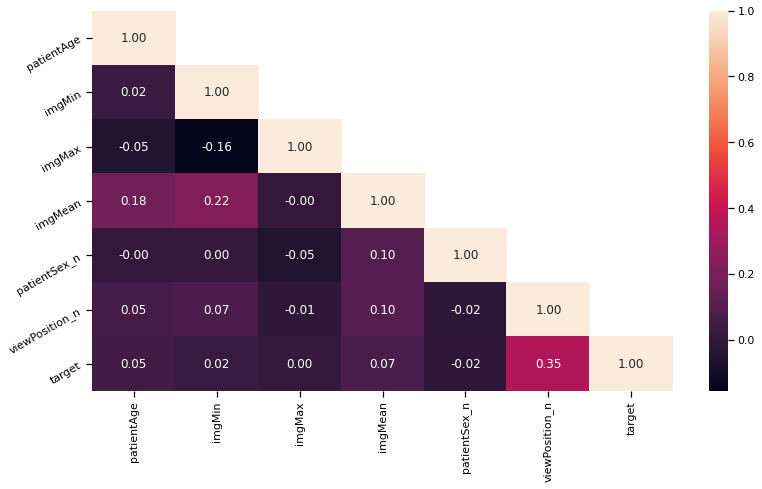

In [ ]:
# Correlation with heat map
corr = train_df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

**From the above correlation matrix, it appears that only viewPosition has the most influence on target class.**

**Lets apply some hypothesis testing to further support our inference.**

**Are older people more likely to get diagnosed with pneumonia?**

(Null Hypothesis) $H_o$ - Older people are more likely to get diagnosed with pneumonia.

$\mu_0 - \mu_1 = 0$

(Alternative Hypothesis) $H_a$ - Older people are not more likely to get diagnosed with pneumonia.

$\mu_0 - \mu_1 \neq 0$

This is a two tailed test because difference may lie in either direction
Use two sample t-test

In [ ]:
from scipy import stats
from scipy.stats import ttest_1samp, ttest_ind, mannwhitneyu, levene, shapiro, f_oneway
from statsmodels.stats.power import ttest_power
from statsmodels.stats.proportion import proportions_ztest

pn = train_df['target']==0
pn_age = train_df[pn].patientAge

no_pn = train_df['target']==1
no_pn_age = train_df[no_pn].patientAge

# two-sample t-test
t_statistic, p_value = ttest_ind(pn_age, no_pn_age)
if p_value < 0.05:
    print(f'With a p-value of {round(p_value,4)} the difference is significant aka We reject the null hypothesis')
    print('Older people are NOT more likely to get diagnosed with pneumonia.')
else:
    print(f'With a p-value of {round(p_value,4)} the difference is not significant. aka We fail to reject the null|')
    print('Older people are more likely to get diagnosed with pneumonia.')

With a p-value of 0.0 the difference is significant aka We reject the null hypothesis
Older people are NOT more likely to get diagnosed with pneumonia.


**Is a specific gender more likely to get diagnosed with pneumonia?**

(Null Hypothesis) $H_o$ - Pneumonia diagnosis is independent of gender.

$\mu_0 - \mu_1 = 0$

(Alternative Hypothesis) $H_a$ - Pneumonia diagnosis is gender dependent.

$\mu_0 - \mu_1 \neq 0$

This is a categorical test.

Chi-Square test is a statistical method to determine if two categorical variables have a significant correlation between them. Both those variables should be from same population and they should be categorical

In [ ]:
# Reload saved csv to avoid working with images again
raw_data_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone Project/data/dcm_meta_with_class.csv')
raw_data_df.head(10)


patientId  ...                         class
0  7494b723-ecdd-4aa6-8e80-833e43943d7b  ...                        Normal
1  a4c04a83-5178-41c3-b300-be73b521947c  ...                  Lung Opacity
2  a4c04a83-5178-41c3-b300-be73b521947c  ...                  Lung Opacity
3  274f1a78-5887-4694-8fd6-a1847d9bc486  ...                  Lung Opacity
4  274f1a78-5887-4694-8fd6-a1847d9bc486  ...                  Lung Opacity
5  45353c0d-842c-416f-9276-8b2de15cd203  ...  No Lung Opacity / Not Normal
6  42bb3786-228b-42c0-bad2-a081993ec38f  ...  No Lung Opacity / Not Normal
7  086b7fd3-3f6e-4701-9da6-921d703fc99d  ...  No Lung Opacity / Not Normal
8  cf398c87-70a2-40f9-aad1-12e30736b888  ...  No Lung Opacity / Not Normal
9  0f8c91da-7e03-480e-8760-1604b1d53c97  ...                        Normal

[10 rows x 7 columns]

In [ ]:
def convert_to_crosstab(col1, col2):
  return pd.crosstab(raw_data_df[col1], raw_data_df[col2])

In [ ]:
crosstab =  convert_to_crosstab("patientSex", "class")

In [ ]:
crosstab

class       Lung Opacity  No Lung Opacity / Not Normal  Normal
patientSex                                                    
F                   2502                          5111    3905
M                   3510                          6710    4946

In [ ]:

import scipy.stats as stats
def do_chisquare(table):
  stat, p, dof, expected = stats.chi2_contingency(table)
  print('dof=%d' % dof)
  print(expected)
  # interpret test-statistic
  prob = 0.95
  critical = stats.chi2.ppf(prob, dof)
  print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
  if abs(stat) >= critical:
	  print('Dependent (reject H0)')
  else:
	  print('Independent (fail to reject H0)')
  # interpret p-value
  alpha = 1.0 - prob
  print('significance=%.3f, p=%.3f' % (alpha, p))
  if p <= alpha:
	  print('Dependent (reject H0)')
  else:
	  print('Independent (fail to reject H0)')


In [ ]:
do_chisquare(crosstab)

dof=2
[[2595.04631989 5102.46882027 3820.48485984]
 [3416.95368011 6718.53117973 5030.51514016]]
probability=0.950, critical=5.991, stat=9.185
Dependent (reject H0)
significance=0.050, p=0.010
Dependent (reject H0)


**Looks like there is a significant relation between pneumonia diagnosis and gender.**

In [ ]:
#chisquare between view position and class
crosstab = convert_to_crosstab('viewPosition', 'class')
crosstab


class         Lung Opacity  No Lung Opacity / Not Normal  Normal
viewPosition                                                    
AP                    4664                          5872    1637
PA                    1348                          5949    7214

In [ ]:
do_chisquare(crosstab)

dof=2
[[2742.6201469  5392.63352571 4037.74632739]
 [3269.3798531  6428.36647429 4813.25367261]]
probability=0.950, critical=5.991, stat=5178.448
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


**As predicted previously, there is a significant relation between CXR view poisition and Pneumonia diagnosis.**

**Approach:**
  1. Convert all dicom images to png/jpg
    a. get pixel_array and use cv2 to write to file as jpg

    b. also resize right here or during imagedatagenerator or pre-stem phase
  2. Create IDG - scale, rotate, flip horizontally
  3. Crate a base model, top layer = false
  4. Create an output layer for binary classification - 2 classes
  5. If time permits - look at ways to combine meta data for classification. Could be as a parallel network feeding into the final classification layer.

In [ ]:
import numpy as np
import pandas as pd

# Reload saved csv to avoid working with images again
#raw_data_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone Project/data/unzip/dcm_meta_with_class.csv')
raw_data_df = pd.read_csv('stage_2_detailed_class_info.csv')
raw_data_df.head(10)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

In [ ]:
from tqdm import tqdm_notebook 
import pydicom as dicom
import os
import cv2
import PIL # optional

def convert_dicom_to_jpg(source_folder, target_folder, class_seg=False):
  for image in tqdm_notebook(os.listdir(source_folder)):
    ds = dicom.dcmread(os.path.join(source_folder, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    if (class_seg==False):
      final_folder = target_folder
    else:
      # get image name and search in pandas for class
      # add class_0, or class_1 as path to store final image in
      pid = image.split('.',1)[0]
      #print(pid)
      #print(raw_data_df.loc[raw_data_df['patientId']==pid, "class"])
      found_class=raw_data_df.loc[raw_data_df['patientId']==pid, "class"].iloc[0]
      if (found_class=='Lung Opacity'):
        final_folder=target_folder+'/class_1'
      else:
        final_folder=target_folder+'/class_0'
    cv2.imwrite(os.path.join(final_folder, image), pixel_array_numpy)
    

In [ ]:
# Specify the .dcm folder path
source_folder_path = "stage_2_train_images"
jpg_folder_path = "content/JPG_train"





In [ ]:
# import shutil
# target_folder = 'content/JPG_train'
# for image in tqdm_notebook(os.listdir('content/JPG_train')):
#       # get image name and search in pandas for class
#       # add class_0, or class_1 as path to store final image in
#       pid = image.split('.',1)[0]
#       #print(pid)
#       #print(raw_data_df.loc[raw_data_df['patientId']==pid, "class"])
#       found_class=raw_data_df.loc[raw_data_df['patientId']==pid, "class"].iloc[0]
#       if (found_class=='Lung Opacity'):
#         final_folder=target_folder+'/class_1'
#       else:
#         final_folder=target_folder+'/class_0'
#       shutil.move('content/JPG_train/' + image, final_folder)
    

In [ ]:
!rm -rf content/JPG_train

In [ ]:
# --- ONE TIME ---
# Ensure folders are created 
!pwd
os.mkdir(jpg_folder_path)
os.mkdir(jpg_folder_path + "/class_1")
os.mkdir(jpg_folder_path + "/class_0")
# !ls -al "{jpg_folder_path}/class_0"

/content


In [ ]:
# convert_dicom_to_jpg(source_folder_path, jpg_folder_path, True)
convert_dicom_to_jpg(source_folder_path, jpg_folder_path, True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# ensure all files are converted - my chrome had crashed twice during the conversion process
#!find "content/JPG_train/class_1" -type f | wc -l

!find "stage_2_train_images" -type f | wc -l

26684


In [ ]:
# --- ONE TIME -- 
# Uncomment only if you need to run it again
# zip train files and move to drive
#!zip -r /content/jpg_train_img.zip /content/JPG_train
#!mv /content/jpg_train_img.zip "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/"
!zip -r /content/jpg_test_img.zip /content/JPG_test
!mv /content/jpg_test_img.zip "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/"

In [1]:
## Copy and unzip jgps back to the runtime
%%time
jpg_zip_path='/content/drive/My Drive/Colab Notebooks/Capstone Project/data/jpg_train_img.zip'
!cp "{jpg_zip_path}" .
!unzip -q jpg_train_img.zip
!rm jpg_train_img.zip
!cd ~
!pwd
!ls -al 

/content
total 24
drwxr-xr-x 1 root root 4096 Sep 25 12:13 .
drwxr-xr-x 1 root root 4096 Sep 25 11:48 ..
drwxr-xr-x 1 root root 4096 Sep 18 16:15 .config
drwxr-xr-x 3 root root 4096 Sep 25 12:12 content
drwx------ 4 root root 4096 Sep 25 12:09 drive
drwxr-xr-x 1 root root 4096 Sep 16 16:29 sample_data
CPU times: user 310 ms, sys: 64.4 ms, total: 374 ms
Wall time: 2min 40s


In [ ]:
!pwd
!ls -al
!ls -al 'content/JPG_train'

/content
total 24
drwxr-xr-x 1 root root 4096 Sep  6 05:06 .
drwxr-xr-x 1 root root 4096 Sep  6 04:56 ..
drwxr-xr-x 1 root root 4096 Aug 31 16:13 .config
drwxr-xr-x 3 root root 4096 Sep  6 05:05 content
drwx------ 4 root root 4096 Sep  6 05:01 drive
drwxr-xr-x 1 root root 4096 Aug 27 16:39 sample_data
total 1840
drwxr-xr-x 4 root root    4096 Sep  2 08:47 .
drwxr-xr-x 3 root root    4096 Sep  6 05:05 ..
drwxr-xr-x 2 root root 1437696 Sep  2 09:09 class_0
drwxr-xr-x 2 root root  438272 Sep  2 09:09 class_1


In [2]:
!mkdir "content/JPG_balanced_train"
!mkdir "content/JPG_balanced_train/class_0"
!mkdir "content/JPG_balanced_train/class_1"

In [3]:
!find "content/JPG_train/class_0" -maxdepth 1 -type f |head -6012|xargs cp -t "content/JPG_balanced_train/class_0"

In [4]:
!find "content/JPG_train/class_1" -maxdepth 1 -type f |head -6012|xargs cp -t "content/JPG_balanced_train/class_1"

In [ ]:

# Lets filter images for patients of age > 18
# This is to check if training without cxrs of minors lead to better learning

adult_patients = raw_data_df[raw_data_df['patientAge']>18]
adult_patients
#patientids = raw_data_df['patientId'].values
#patientids

patientId  ...                         class
0      7494b723-ecdd-4aa6-8e80-833e43943d7b  ...                        Normal
1      a4c04a83-5178-41c3-b300-be73b521947c  ...                  Lung Opacity
2      a4c04a83-5178-41c3-b300-be73b521947c  ...                  Lung Opacity
3      274f1a78-5887-4694-8fd6-a1847d9bc486  ...                  Lung Opacity
4      274f1a78-5887-4694-8fd6-a1847d9bc486  ...                  Lung Opacity
...                                     ...  ...                           ...
30221  3eccadbe-e821-4487-afe7-2bc5f2ee5774  ...                  Lung Opacity
30222  a2961d70-7b12-4eac-bb33-8567bba2d3e9  ...                  Lung Opacity
30223  ff1c102f-8294-4156-8771-aab8c6f9a819  ...  No Lung Opacity / Not Normal
30224  ebd485b0-e788-44e2-8f85-a98a6cb2d153  ...  No Lung Opacity / Not Normal
30225  a03a2aab-7039-4743-9dab-3870899b1f35  ...                  Lung Opacity

[28529 rows x 7 columns]

In [ ]:
!mkdir 'content/JPG_adults_all'
!mkdir 'content/JPG_adults_all/class_0'
!mkdir 'content/JPG_adults_all/class_1'


In [ ]:
import shutil, os
from tqdm import tqdm_notebook

img_base_path = 'content/JPG_train/'
target_path = 'content/JPG_adults_all/'
for idx, row in tqdm_notebook(raw_data_df.iterrows()):
  # check if
  pid = row['patientId']
  if (row['class'] == 'Lung Opacity'):
    folder = 'class_1/'
  else:
    folder = 'class_0/'
  f = img_base_path + folder + pid + ".jpg"

  shutil.copy(f, target_path + folder)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


**Ready to create Models**

In [ ]:

import tensorflow as tf
print(tf.__version__)
# imports for the model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2

# imports for the dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

2.3.0


In [ ]:

from keras.preprocessing.image import ImageDataGenerator


#BASE_MODEL= 'XCEPTION'
BASE_MODEL= 'RESNET50'

if BASE_MODEL=='RESNET50':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET152':
    from keras.applications.resnet import ResNnet152 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [ ]:

# Image Augmentation - data generator for training
#TRAIN_DIR = 'content/JPG_train'
# todo: Messup while unzipping - will fix it when next we have to redo the process
TRAIN_DIR = 'content/JPG_balanced_train'
SAVE_DIR = 'content/JPG_Augmented/'
datagen = ImageDataGenerator( preprocessing_function=preprocess_input,                            
                             horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 30, 
                              fill_mode = 'nearest',
                              zoom_range = 0.3,
                              validation_split=0.3 )
# Trying with no data augmentation
# datagen = ImageDataGenerator( preprocessing_function=preprocess_input, 
#                              validation_split=0.3)

BATCH_SIZE = 500
print("Training Data Generator")
train_generator = datagen.flow_from_directory(TRAIN_DIR, subset='training',
                                              target_size = (224, 224),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

print("Validation Data Generator")
val_generator = datagen.flow_from_directory(TRAIN_DIR,
                                            subset='validation',
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'binary')
## Generate and save augmented images
# train_save = datagen.flow_from_directory(TRAIN_DIR, subset='training',
#                                               target_size = (1024, 1024),
#                                                  batch_size = BATCH_SIZE,
#                                                  class_mode = 'binary',
#                                                  save_to_dir=SAVE_DIR + "training/",
#                                                   save_prefix="",
#                                                   save_format="jpeg")


# val_save = datagen.flow_from_directory(TRAIN_DIR,
#                                             subset='validation',
#                                             target_size = (1024, 1024),
#                                             batch_size = BATCH_SIZE,
#                                             class_mode = 'binary',
#                                             save_to_dir=SAVE_DIR + "validation/",
#                                             save_prefix="",
#                                             save_format="jpeg")

# i=0
# for batch in train_save:
#   i+=1
#   if (i>20):
#     break


Training Data Generator
Found 7000 images belonging to 2 classes.
Validation Data Generator
Found 3000 images belonging to 2 classes.


**Here we see what the augmentation actually looks like on a few sample images**

(500, 224, 224, 3) (500,)


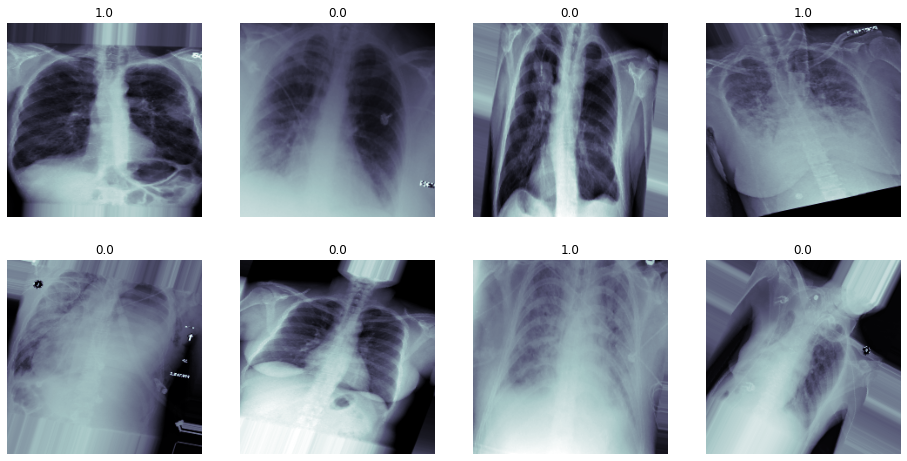

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

t_x, t_y = next(train_generator)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % (c_y))
    c_ax.axis('off')

In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, Flatten, Input, Conv2D, multiply, AvgPool2D, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras import layers
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import activations, regularizers
import pandas as pd
from keras.metrics import Precision, Recall




In [ ]:
base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/"
#base_path=""
def get_callbacks(save_file_name):
    weight_path=base_path + "model/{}.best.hdf5".format(save_file_name)
    checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='auto', save_weights_only = False, )
    
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, 
                                   patience=3, verbose=1, mode='auto',
                                   cool_down=2, 
                                   min_delta=0.0001,  min_lr=0.0)
    
    early = EarlyStopping(monitor="val_accuracy", mode="auto", patience=10) 
    
    return [checkpoint, early, reduceLROnPlat]

In [ ]:
def add_regularization(model, regularizer=tf.keras.regularizers.l1(), from_layer=81):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers[from_layer:]:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              #print("adding reg to layer ", layer.name)
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()
    
    # Save the weights before reloading the model.
    # tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    # model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    # model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:

def get_model(opt, train_from_layer, dense_count, drop_out, fc, reg=False, reg_from=81):
    
    base_pretrained_model = PTModel(input_shape =  t_x.shape[1:],include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    

    if (reg==True):
        base_pretrained_model = add_regularization(base_pretrained_model, from_layer=reg_from)
    
    x = base_pretrained_model.output

    # --------------------------------------- FC1
    if (fc=='FC1'):
      # model = BatchNormalization()(x)
      model = GlobalAveragePooling2D()(x)
      model = Dense(1024,  activation = 'relu')(model)
      # model=LeakyReLU(0.01)(model)
      model=Dropout(0.10)(model)
      #model=BatchNormalization()(model)
      model = Dense(512, activation = 'relu')(model)
      # model=LeakyReLU(0.01)(model)
      # model=Dropout(DROPOUT)(model)
      # model=BatchNormalization()(model)
    elif (fc=='FC2'):
      # --------------------------------------- FC2
      model = Flatten()(x)
      model = Dense(units = dense_count, activation = 'relu')(model)
      model=Dropout(drop_out)(model)
    elif (fc=='FC3'):
      # --------------------------------------- FC3
      model = BatchNormalization()(x)
      model = GlobalAveragePooling2D()(model)
      model = Dense(dense_count, activation=activations.relu, kernel_regularizer='l1')(model)
      # model = Dense(dense_count, activation=activations.relu)(model)
      model = Dropout(drop_out)(model)
    elif (fc=='FC4'):
    
      # ------------------------------------------ FC4
      model = BatchNormalization()(x)
      model = GlobalMaxPooling2D()(model)
      model = Dropout(drop_out)(model)
    # ------------------------------------------
    # Since this is a binary classification problem, we are using sigmoid activation
    out_layer = Dense(1, activation = 'sigmoid')(model)

    model = Model(inputs = base_pretrained_model.input, outputs = [out_layer], name = 'trained_model')
    
    for layer in base_pretrained_model.layers:
      # fix the feature extraction part of the model
      # if isinstance(layer, BatchNormalization):
      #   layer.trainable = True
      # else:
        layer.trainable = False
    
    if (train_from_layer>=0):
      for layer in base_pretrained_model.layers[train_from_layer:]:
        layer.trainable = True
    
        
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [ ]:

def model_fit(model, callbacks, epochs, batch_size, hist_file_name):
  

  model.fit(train_generator, 
               validation_data=val_generator,
               epochs=epochs,
               batch_size=batch_size, 
               verbose=1,
               callbacks=callbacks)
  hist_df = pd.DataFrame(model.history.history)

  hist_csv_file = base_path + "model/train_history_{}.csv".format(hist_file_name)
  with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)



**We will first try to train just the output classifier, keeping the pretrained ResNet50 layers frozen.**

**Post that, we will try to unfreeze the top couple of conv layers and train them.** 


In [ ]:
%%time
import pandas as pd
from collections import Counter

DENSE_COUNT = 1024 # [32, 64, 128, 256]
DROPOUT = 0.50 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]


# counter = Counter(train_generator.classes)                          
# max_val = float(max(counter.values()))       
# class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

# define adam optimizer
# adam = Adam(learning_rate=LEARN_RATE, beta_1=0.5 )
adam = Adam(learning_rate=LEARN_RATE)

#define SGD optimizer
#sgd = SGD(lr=LEARN_RATE, momentum=0.8)
sgd = SGD(lr = LEARN_RATE, decay = 1e-6, momentum = 0.9, nesterov = True)

# get model
fc='FC1'
model = get_model(sgd, -1, DENSE_COUNT, DROPOUT, fc='FC1')
# load pretrained weights saved earlier
#model.load_weights(base_path + 'model/onlyfc_do-25-ds-128-batch-8-adam-l1reg-lr1e2-balance-origsize-fc-3-1.best.hdf5')
save_file_name=("onlyfc-{}_nodo-ds-{}-batch-500-sgd-lr1e4-l2-balance-0").format(fc, DENSE_COUNT)
cblist = get_callbacks(save_file_name)
model_fit(model, cblist, 50, BATCH_SIZE, save_file_name)

Model: "trained_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
# model = tf.keras.models.load_model(base_path + 'model/onlyfc_do-25-ds-128-batch-8-adam-l1reg-lr1e2-balance-origsize-fc-3-1.best.hdf5')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# val_generator.reset()
t_x, t_y = next(val_generator)
#print("t_y", t_y)
#Y_pred=model.predict(val_generator)
Y_pred=model.predict(t_x)
y_pred = np.where(Y_pred>0.5, 1, 0)

print("Confusion Matrix")
#cm = confusion_matrix(val_generator.classes, y_pred)
cm = confusion_matrix(t_y, y_pred)
print(cm)
#print(val_generator.classes)
print("Classification Report")
target_names = ['No Lung Opacity', 'Lung Opacity']
#print(classification_report(val_generator.classes, y_pred))
print(classification_report(t_y, y_pred))



Confusion Matrix
[[168  74]
 [ 79 179]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.69       242
         1.0       0.71      0.69      0.70       258

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500



   Predict 1  Predict 0
1        168         74
0         79        179


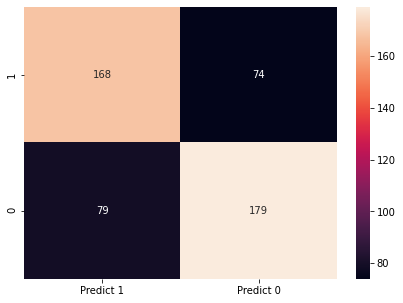

In [ ]:

from matplotlib import pyplot as plt
import cv2
import seaborn as sns

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
print(df_cm)
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')


In [ ]:
# Plot graphs
def plot_training_graphs(label_txt, history_file):
  # Load saved history_file
  hist_df = pd.read_csv(history_file)
  # summarize history for accuracy
  print(label_txt, history_file)
  plt.figure(1, figsize = (15,8))
  plt.subplot(221)  
  plt.plot(hist_df['accuracy'])  
  plt.plot(hist_df['val_accuracy'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'valid']) 
      
  plt.subplot(222)  
  plt.plot(hist_df['loss'])  
  plt.plot(hist_df['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'valid']) 

  plt.show()


SGD, No Image Augmentation /content/drive/My Drive/Colab Notebooks/Capstone Project/model/train_history_onlyfc-FC1_do-50-ds-256-batch-100-adam-lr1e2-balance-0.csv


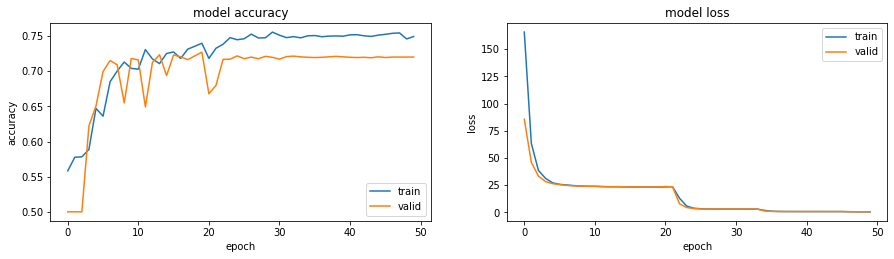

In [ ]:
# Plot Iteration 1
base_drive_path = "/content/drive/My Drive/Colab Notebooks/Capstone Project/model/"
histories = {
              "SGD, No Image Augmentation":"train_history_onlyfc-FC1_do-50-ds-256-batch-100-adam-lr1e2-balance-0.csv"
              
             }

for key, value in histories.items():
  plot_training_graphs(key, base_drive_path+value)

In [ ]:
!rm -rf "content/features/part/*"

**Try to generate features from pretrained network and then pass these features to train just the classifier. This makes the learning process extremely fast.**

In [ ]:

import tensorflow as tf
print(tf.__version__)
# imports for the model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

2.3.0


In [ ]:




BASE_MODEL= 'VGG16'
#BASE_MODEL= 'RESNET50'



if BASE_MODEL=='RESNET50':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='VGG16':
    from keras.applications import VGG16 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [ ]:
# Image Augmentation - data generator for training
#TRAIN_DIR = 'content/JPG_train'
# todo: Messup while unzipping - will fix it when next we have to redo the process
TRAIN_DIR = 'content/JPG_balanced_train'
SAVE_DIR = 'content/JPG_Augmented/'
datagen = ImageDataGenerator( preprocessing_function=preprocess_input, 
                             horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 60, 
                              fill_mode = 'nearest',
                              zoom_range = 0.5,
                              validation_split=0.2 )

# datagen = ImageDataGenerator( preprocessing_function=preprocess_input,
#                               #horizontal_flip = True,
#                               #zoom_range = 0.3,
#                               validation_split=0.2)
# Trying with no data augmentation
# datagen = ImageDataGenerator( preprocessing_function=preprocess_input, 
#                              validation_split=0.3)

BATCH_SIZE = 8
print("Training Data Generator")
train_generator = datagen.flow_from_directory(TRAIN_DIR, subset='training',
                                              target_size = (224, 224),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

print("Validation Data Generator")
val_generator = datagen.flow_from_directory(TRAIN_DIR,
                                            subset='validation',
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'binary')

Training Data Generator
Found 9620 images belonging to 2 classes.
Validation Data Generator
Found 2404 images belonging to 2 classes.


In [ ]:
! rm -rf content/features/part/*

In [ ]:
# features_train = base_model.predict(train_generator, 15000)
# print("---> training features generated", features_train.shape)

# np.save(base_path + 'features_train.npy', features_train)

# train_labels = train_generator.classes
# np.save(base_path+'train_labels.npy', train_labels)

# features_validation = base_model.predict(val_generator, 8000)
# print("---> validation features generated", features_validation.shape)

# np.save(base_path + 'features_validate.npy', features_validation)

# validation_labels = val_generator.classes
# np.save(base_path+'validation_labels.npy', train_labels)


In [ ]:
input_sizes = [(224, 224), (512, 512)]
features_dim = [[7,7,2048],[16,16,2048]]

t_x, t_y = next(train_generator)
print("Image Shape:",t_x.shape)
train_generator.reset()
base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/features/"

work_size = 0

base_model = PTModel(input_shape=t_x.shape[1:], weights='imagenet', include_top=False)


Image Shape: (8, 224, 224, 3)


In [ ]:
from tqdm import tqdm

def get_features(generator, n, save_to_file):
    current_iteration = 0
    pred_lst = []
    label_lst = []
    with tqdm(total=n) as pbar:
        for x, y in generator:
            prediction = base_model.predict(x)
            pred_lst.append(prediction)
            label_lst.append(y)
            preds_tmp = np.vstack(pred_lst)
            pbar.update(1)
            current_iteration += 1
            if current_iteration >= n:
                break

    print("features generated", preds_tmp.shape, current_iteration)
    np.save(base_path + "feat_" +save_to_file +".npy", preds_tmp)
    labels_tmp = np.ravel(label_lst)
    labels_tmp = np.concatenate(labels_tmp)

    np.save(base_path + "label_" +save_to_file +".npy", labels_tmp)
        
    return preds_tmp, labels_tmp


In [ ]:
from tqdm import tqdm
# base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/features/"
base_path="content/features"
base_part_path=base_path + "/part"

def extract_features(generator, n, save_to_file):
    
    current_iteration = 0
    #file_current_iteration = 2500 + current_iteration

    with tqdm(total=n) as pbar:
        for x, y in generator:
            prediction = base_model.predict(x)
            #print("{} - features generated - {} ".format(current_iteration, prediction.shape))
            
            tname = "{}/feat_{}_{}.npy".format(base_part_path, save_to_file, current_iteration)
            lname = "{}/label_{}_{}.npy".format(base_part_path, save_to_file, current_iteration)
            
            np.save(tname, prediction)
            np.save(lname, y)
            pbar.update(1)
            current_iteration += 1
            if current_iteration > n:
                break
    

In [ ]:
!find "/content/drive/My Drive/Colab Notebooks/Capstone Project/features/part/" -type f | wc -l

13246


In [ ]:
train_file = "training-224-aug"
val_file = "validation-224-aug"

# train_features, train_labels = get_features(train_generator, 2500, train_file)

# validation_features, validation_labels = get_features(val_generator, 800, val_file)

extract_features(train_generator, 5000, train_file)
extract_features(val_generator, 1600, val_file)



5001it [17:34,  4.74it/s]
1601it [05:25,  4.92it/s]


In [ ]:
# --- ONE TIME ---
# Ensure folders are created 
!rm -rf content/features/part/
# !pwd
# feature_path = 'content/features/'
# !mkdir -p "{feature_path}"

# !cp -r "/content/drive/My Drive/Colab Notebooks/Capstone Project/features/part" "{feature_path}"

In [ ]:
!find "content/features/part" -type f | wc -l

7014


In [ ]:
train_features = train_feautres

In [ ]:
# train_labels = np.concatenate(train_labels)
# validation_labels = np.concatenate(validation_labels)
print(np.unique(train_labels))
print(np.unique(validation_labels))

[0. 1.]
[0. 1.]


In [ ]:
#train_labels = np.concatenate(train_labels)
#validation_labels = np.concatenate(validation_labels)
# print(validation_labels_tmp.shape)
# print(validation_labels_tmp)
#print(validation_labels)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime, os

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
# Create a custom Data Generator
# Read npy files and return a tuple with features and label

import os


class TrainDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs):
        'Initialization'
        self.list_IDs = list_IDs
        self.on_epoch_end()

    def __len__(self):
      'Denotes the number of batches per epoch'
      return int(len(self.list_IDs))

    def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index:(index+1)]

      # Find list of IDs
      list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
      X, y = self.__data_generation(list_IDs_temp)

      return X, y

    def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.list_IDs))
      np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
      'Generates data containing batch_size samples'
      data_loc = "content/features/part"
      train_file_name = "feat_training-224-aug_{}.npy"
      label_file_name = "label_training-224-aug_{}.npy"
      # Generate data
      for ID in list_IDs_temp:
          x_file_path = os.path.join(data_loc, train_file_name.format(ID))
          y_file_path = os.path.join(data_loc, label_file_name.format(ID))

          # Store sample
          X = np.load(x_file_path)

          # Store class
          y = np.load(y_file_path)

      return X, y

class ValidationDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs):
        'Initialization'
        self.list_IDs = list_IDs
        self.on_epoch_end()

    def __len__(self):
      'Denotes the number of batches per epoch'
      return int(len(self.list_IDs))

    def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index:(index+1)]

      # Find list of IDs
      list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
      X, y = self.__data_generation(list_IDs_temp)

      return X, y

    def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.list_IDs))
      np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
      'Generates data containing batch_size samples'
      data_loc = "content/features/part"
      train_file_name = "feat_validation-224-aug_{}.npy"
      label_file_name = "label_validation-224-aug_{}.npy"
      # Generate data
      for ID in list_IDs_temp:
          x_file_path = os.path.join(data_loc, train_file_name.format(ID))
          y_file_path = os.path.join(data_loc, label_file_name.format(ID))

          # Store sample
          X = np.load(x_file_path)

          # Store class
          y = np.load(y_file_path)

      return X, y

In [ ]:
train_sample_count = 5000
validation_sample_count = 1600
train_seq_list = np.arange(train_sample_count)
val_seq_list = np.arange(validation_sample_count)

# check that the generator is working as expected
training_generator = TrainDataGenerator(train_seq_list)
validation_generator = ValidationDataGenerator(val_seq_list)
t_x,y = training_generator.__getitem__(1)
print(y)
print(t_x.shape)


[0. 1. 0. 1. 1. 0. 0. 1.]
(8, 7, 7, 2048)


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

def get_cb(save_file_name):
  weight_path=base_path + "model/{}.hdf5".format(save_file_name)
  checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                          save_best_only=True, mode='auto', save_weights_only = False, )

  reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                patience=10, verbose=1, mode='auto',
                                cool_down=5, 
                                min_delta=0.0001,  min_lr=0.0)

  early = EarlyStopping(monitor="val_loss", mode="auto", patience=10) 
  #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  return [early, checkpoint] #, reduceLROnPlat,tensorboard_callback]

In [ ]:
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.regularizers import l2,l1, l1_l2
from keras.optimizers import SGD, Adam, Nadam, RMSprop,Adagrad
import pandas as pd

SEED = 42
np.random.seed(SEED)
#input_shape = train_features.shape[1:]
input_shape = t_x.shape[1:]

model = Sequential()

#model.add(Flatten(input_shape=input_shape))
# model.add(GlobalAveragePooling2D(input_shape=input_shape))
#model.add(GlobalMaxPooling2D(input_shape=train_feautres.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(BatchNormalization())

model.add(Dropout(0.60))

model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)))
model.add(BatchNormalization())
model.add(Dropout(0.50))

# model.add(Dense(28, activation='relu', kernel_initializer=glorot_uniform(seed=SEED), kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.50))
# ---------------------------------
### Reached >80% val accuracy with 512x512 images - only about 2.4k train and 800 val images
# model.add(Flatten(input_shape=train_feautres.shape[1:]))


# model.add(BatchNormalization())
# model.add(Dropout(0.50))

# model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)))
# model.add(BatchNormalization())
# model.add(Dropout(0.50))

# model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=SEED),  kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.30))


#-----------------------------
### Good Convergence upto >74% - Training and Validation Accuracy and Loss tracking each other.
### Looks like some capacity could be added for the network to learn
# model.add(BatchNormalization())
# model.add(Dropout(0.60))

# model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)))
# model.add(BatchNormalization())
# model.add(Dropout(0.60))

# model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)))
# model.add(BatchNormalization())
# model.add(Dropout(0.60))

#---------------------
# 
# model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01), kernel_initializer=glorot_uniform(seed=SEED)))
# model.add(Dropout(0.50))
# # model.add(BatchNormalization())
# model.add(Dense(256, activation='relu',  kernel_regularizer=l1(0.01),kernel_initializer=glorot_uniform(seed=SEED)))

# #model.add(Dropout(0.50))
# # # model.add(BatchNormalization())
# # model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01),kernel_initializer=glorot_uniform(seed=SEED)))

#---------------------
# Good convergence - upto 74%
# model.add(Flatten(input_shape=train_feautres.shape[1:]))
# model.add(BatchNormalization())
# model.add(Dropout(0.60))

# model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)))
# model.add(BatchNormalization())
# model.add(Dropout(0.50))

model.add(Dense(1, activation='sigmoid',  kernel_initializer=glorot_uniform(seed=SEED)))


In [ ]:
%tensorboard --logdir logs

In [ ]:
base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/features/model"
save_file_name = "feature_model-224-20k"

model.load_weights(os.path.join(base_path, save_file_name + ".hdf5"))

In [ ]:
# USING CUSTOM DATA GENERATOR FOR 224x224/1024x1024 image features
base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/features/"
save_file_name = "feature_model-224-20k"
hist_seq = 0
hist_csv_file = base_path + "model/history_{}-{}.csv".format(save_file_name, hist_seq)
#, momentum=0.95, nesterov=True
LR = 1e-4
#opt = SGD(LR)
opt = Adam(LR)
cb = get_cb(save_file_name = save_file_name)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("features_train.shape:",t_x.shape)
model.fit(training_generator, 
          validation_data=validation_generator,
          epochs=100,
          #steps_per_epoch = 24,
          batch_size=2,
          callbacks= cb)
hist_df = pd.DataFrame(model.history.history)


with open(hist_csv_file, mode='w') as f:
  hist_df.to_csv(f)

features_train.shape: (8, 7, 7, 2048)
Epoch 1/100
5000/5000 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.6552
Epoch 00001: val_accuracy improved from -inf to 0.75430, saving model to /content/drive/My Drive/Colab Notebooks/Capstone Project/features/model/feature_model-224-20k.hdf5
5000/5000 [==============================] - 574s 115ms/step - loss: 0.7502 - accuracy: 0.6552 - val_loss: 0.5106 - val_accuracy: 0.7543
Epoch 2/100
5000/5000 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.6983
Epoch 00002: val_accuracy improved from 0.75430 to 0.76448, saving model to /content/drive/My Drive/Colab Notebooks/Capstone Project/features/model/feature_model-224-20k.hdf5
5000/5000 [==============================] - 553s 111ms/step - loss: 0.6017 - accuracy: 0.6983 - val_loss: 0.4981 - val_accuracy: 0.7645
Epoch 3/100
5000/5000 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.7224
Epoch 00003: val_accuracy improved from 0.76

FileNotFoundError: ignored

In [ ]:
base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/features/"
save_file_name = "feature_model-224-aug"
hist_seq = 0
hist_csv_file = base_path + "model/history_{}-{}.csv".format(save_file_name, hist_seq)
#, momentum=0.95, nesterov=True
LR = 1e-4
#opt = SGD(LR, momentum=0.85, nesterov=True)
opt = Adam(LR)
cb = get_cb(save_file_name = save_file_name)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("features_train.shape:",train_feautres.shape)
model.fit(train_feautres, train_labels,
          epochs=200,
          batch_size=64,
          callbacks= cb,
          validation_data=(validation_features, validation_labels))
hist_df = pd.DataFrame(model.history.history)


with open(hist_csv_file, mode='w') as f:
  hist_df.to_csv(f)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Y_pred=model.predict(validation_features)
X=[]
y=[]
for ii in np.arange(200):
  X_tmp, y_tmp = validation_generator.__getitem__(ii)
  X.append(X_tmp)
  y.append(y_tmp)

X = np.vstack(X)
y = np.concatenate(y)
print(X.shape, y.shape)

Y_pred=model.predict(X)
y_pred = np.where(Y_pred>0.5, 1, 0)

print("Confusion Matrix")
cm = confusion_matrix(y, y_pred)
# cm = confusion_matrix(validation_labels, y_pred)
print(cm)

print("Classification Report")
target_names = ['No Lung Opacity', 'Lung Opacity']
print(classification_report(y, y_pred))
# print(classification_report(validation_labels, y_pred))

(1600, 7, 7, 2048) (1600,)
Confusion Matrix
[[632 165]
 [229 574]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       797
         1.0       0.78      0.71      0.74       803

    accuracy                           0.75      1600
   macro avg       0.76      0.75      0.75      1600
weighted avg       0.76      0.75      0.75      1600



In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


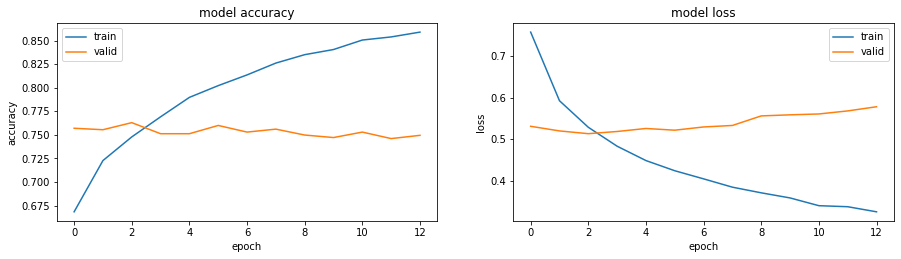

In [ ]:
# Plot graphs
plt.figure(1, figsize = (15,8))
plt.subplot(221)  
plt.plot(hist_df['accuracy'])  
plt.plot(hist_df['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
  
plt.subplot(222)  
plt.plot(hist_df['loss'])  
plt.plot(hist_df['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

**ChexNet with Densenet Backbone**

In [5]:
!pip install lime

     |████████████████████████████████| 276kB 5.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=518f6081cfe678f04e94518f50d25c657781da40130fcf148ad6b0cb3911c0a5
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [6]:
!cp "/content/drive/My Drive/Colab Notebooks/Capstone Project/chexnet/CheXNet_v0.3.0.h5" /content/content/.

In [8]:
from lime import lime_image
from tensorflow.keras import Model
import tensorflow as tf, numpy as np, cv2.cv2 as cv2

def generate_explanation(model, input_image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image=input_image, classifier_fn=model.predict, hide_color=0,
                                             num_samples=1000, random_seed=18)
    temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0], positive_only=True, num_features=5,
                                                hide_rest=False)
    return temp, mask


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, normalize=True):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.input], outputs=[self.model.get_layer(self.layerName).output,
                                                              self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            inputs = np.expand_dims(inputs, axis=0)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # if gradients are too small (GradCAM is zero everywhere)
        # equal to changing the value of 'eps' func arg
        grads = grads / (grads.numpy().max() - grads.numpy().min())
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        h, w = image.shape[:2]
        heatmap = cv2.resize(cam.numpy(), (w, h))
        print('avg heatmap value:', np.mean(heatmap))
        print('max heatmap value:', np.max(heatmap))
        # ignore certain values lower than a threshold to get sharper heatmaps
        # heatmap[np.where(heatmap < 1)] = 0
        if normalize:
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255)
        return heatmap.astype("uint8")

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # if the input image is grey-scale, convert it to 3-dim
        if len(image.shape) == 2 or image.shape[-1] != 3:
            image = cv2.cvtColor(src=image, code=cv2.COLOR_GRAY2RGB)
        # if image px values are in [0, 1], upscale to [0, 255]
        if np.max(image) <= 1.0:
            image = image * 255.0
        output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        return output

In [9]:
from keras.preprocessing.image import load_img, img_to_array
import cv2.cv2 as cv2, numpy as np
from keras.applications import DenseNet121

from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import Model

from keras.initializers import glorot_uniform
#from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.regularizers import l2,l1, l1_l2
from keras.optimizers import SGD, Adam, Nadam, RMSprop,Adagrad
import pandas as pd


IMG_SHAPE = (320, 320, 3)

backbone = DenseNet121(include_top=False, weights=None, input_shape=(320, 320, 3))
backbone_out = backbone.output

# Following layers are just to allow adding pre-trained chexnet weights
# Will be removed after weights are loaded
gap = GlobalAveragePooling2D(name='pooling_layer')(backbone_out)
output = Dense(units=14, activation='relu', name='output_layer')(gap)
chexnet_model = Model(inputs=backbone.input, outputs=output)
chexnet_model.summary()

# Load chexNet weights
base_path="/content/drive/My Drive/Colab Notebooks/Capstone Project/chexnet/"
chexnet_model.load_weights('/content/content/CheXNet_v0.3.0.h5')



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
#chexnet_model.compile(optimizer='adam', loss='binary_crossentropy')

#chexnet_model.save(filepath=base_path + 'checkpoints/CheXNet/CheXNet_model.hdf5')
#print('sample prediction: \n', chexnet_model.predict(np.expand_dims(test_img, axis=0)))


# classifier.summary()
#print('number of pretrained network layers:', len(classifier.layers))

In [10]:
## What we can also do is to reuse the original chexnet model and use 
## only the pneumonia class output, ignoring rest of the classes.
## This way we will not have to train the model again. 
## Since we are reducing the classes, the model will essentially be trained again.


# Pop the final 2 layers and add own classifier - pop doesnt work so we'll add a new head
gap = GlobalAveragePooling2D(name='pooling_layer')(backbone_out)
fc1 = Dense(10, activation='relu', name='fc')(gap)
do = Dropout(rate=0.2, name='dropout')(fc1)
# fc2 = Dense(units=7, activation='sigmoid', name='fc2_layer')(do)
# do2 = Dropout(rate=0.2, name='dropout2_layer')(fc2)
output1 = Dense(1, activation='sigmoid', name='pred')(do)
chexnet_model = Model(inputs=backbone.input, outputs=output1)

# for layer in chexnet_model.layers[:-6]:
#     layer.trainable = False



In [ ]:
!mkdir "content/JPG_balanced_train"
!mkdir "content/JPG_balanced_train/class_0"
!mkdir "content/JPG_balanced_train/class_1"

In [ ]:
!find "content/JPG_train/class_0" -maxdepth 1 -type f |head -1000|xargs cp -t "content/JPG_balanced_train/class_0"

In [ ]:
!find "content/JPG_train/class_1" -maxdepth 1 -type f |head -1000|xargs cp -t "content/JPG_balanced_train/class_1"

In [20]:
from keras.preprocessing.image import ImageDataGenerator
# Image Augmentation - data generator for training
#TRAIN_DIR = 'content/JPG_train'
# todo: Messup while unzipping - will fix it when next we have to redo the process
TRAIN_DIR = 'content/JPG_balanced_train'
# TRAIN_DIR = 'content/JPG_adults_all'
SAVE_DIR = 'content/JPG_Augmented/'
datagen = ImageDataGenerator( 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              zoom_range=[0.8, 1.5],
                              #brightness_range=[0.5, 1.3],
                              rescale=1./255,
                              height_shift_range = 0.2, 
                              width_shift_range = 0.2, 
                              rotation_range = 20, 
                              # fill_mode = 'nearest',
                              validation_split=0.2 )

# datagen = ImageDataGenerator( preprocessing_function=preprocess_input,
#                               #horizontal_flip = True,
#                               #zoom_range = 0.3,
#                               validation_split=0.2)
# Trying with no data augmentation
# datagen = ImageDataGenerator( preprocessing_function=preprocess_input, 
#                              validation_split=0.3)

BATCH_SIZE = 16
print("Training Data Generator")
train_generator = datagen.flow_from_directory(TRAIN_DIR, subset='training',
                                              target_size = (320, 320),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

print("Validation Data Generator")
val_generator = datagen.flow_from_directory(TRAIN_DIR,
                                            subset='validation',
                                            target_size = (320, 320),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'binary')

Training Data Generator
Found 9620 images belonging to 2 classes.
Validation Data Generator
Found 2404 images belonging to 2 classes.


In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath=base_path +'checkpoints/best-bal-2.hdf5',
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                patience=3, verbose=1, mode='auto',
                                min_delta=0.0001,  min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", mode="auto", patience=5) 
  

  
cb = [checkpoint, early] #, reduceLROnPlat]

In [27]:
LR = 1e-2
opt = Adam(learning_rate=LR)
#opt = SGD(LR, momentum=0.85, nesterov=True)


chexnet_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
chexnet_model.load_weights(base_path +'checkpoints/best-bal.hdf5')

In [29]:


chexnet_model.fit(train_generator, 
          validation_data=val_generator,
          epochs=20,
          batch_size=BATCH_SIZE,
          callbacks= cb)

hist_df = pd.DataFrame(chexnet_model.history.history)


with open(base_path+'checkpoints/hist-bal-3.csv', mode='w') as f:
  hist_df.to_csv(f)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.6243
Epoch 00001: val_loss did not improve from 0.43192
602/602 [==============================] - 306s 509ms/step - loss: 0.6547 - accuracy: 0.6243 - val_loss: 0.7093 - val_accuracy: 0.6997
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.6432
Epoch 00002: val_loss did not improve from 0.43192
602/602 [==============================] - 306s 508ms/step - loss: 0.6371 - accuracy: 0.6432 - val_loss: 0.9408 - val_accuracy: 0.5437
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.6532
Epoch 00003: val_loss did not improve from 0.43192
602/602 [==============================] - 306s 508ms/step - loss: 0.6344 - accuracy: 0.6532 - val_loss: 0.6355 - val_accuracy: 0.6531
Epoch 4/20
602/602 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6572
Epoch 00004: val_loss did not improve from 0.43192
602/602

In [23]:
from sklearn.metrics import classification_report, confusion_matrix


# Y_pred=model.predict(validation_features)
X=[]
y=[]
for ii in np.arange(100):
  X_tmp, y_tmp = next(val_generator)
  X.append(X_tmp)
  y.append(y_tmp)

X = np.vstack(X)
y = np.concatenate(y)
print(X.shape, y.shape)

Y_pred=chexnet_model.predict(X)
y_pred = np.where(Y_pred>0.5, 1, 0)

print("Confusion Matrix")
cm = confusion_matrix(y, y_pred)
# cm = confusion_matrix(validation_labels, y_pred)
print(cm)

print("Classification Report")
target_names = ['No Lung Opacity', 'Lung Opacity']
print(classification_report(y, y_pred))
# print(classification_report(validation_labels, y_pred))

(1600, 320, 320, 3) (1600,)
Confusion Matrix
[[638 151]
 [152 659]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       789
         1.0       0.81      0.81      0.81       811

    accuracy                           0.81      1600
   macro avg       0.81      0.81      0.81      1600
weighted avg       0.81      0.81      0.81      1600



   Predict 1  Predict 0
1        638        151
0        152        659


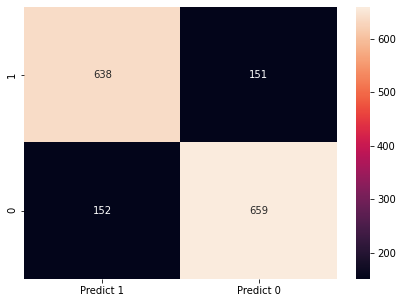

In [30]:
from matplotlib import pyplot as plt
import cv2
import seaborn as sns

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
print(df_cm)
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')


In [16]:
history_file=base_path+'checkpoints/hist-bal.csv'
hist_df = pd.read_csv(history_file)

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


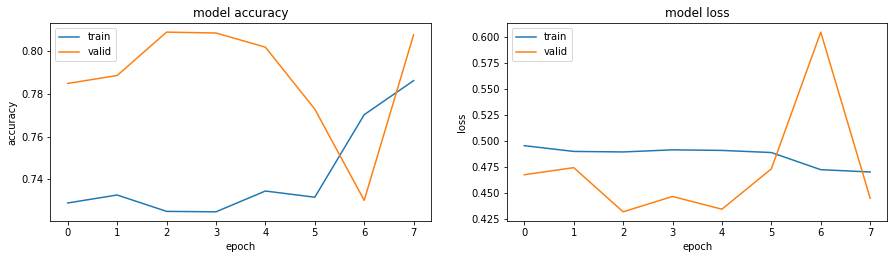

In [24]:
# Plot graphs
plt.figure(1, figsize = (15,8))
plt.subplot(221)  
plt.plot(hist_df['accuracy'])  
plt.plot(hist_df['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
  
plt.subplot(222)  
plt.plot(hist_df['loss'])  
plt.plot(hist_df['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

avg heatmap value: 4.8272023
max heatmap value: 19.042194
avg heatmap value: 4.4476624
max heatmap value: 21.43621
avg heatmap value: 4.7630424
max heatmap value: 25.661749
avg heatmap value: 1.9899658
max heatmap value: 4.69931
avg heatmap value: 6.1548223
max heatmap value: 17.106438
avg heatmap value: 6.108455
max heatmap value: 16.232777
avg heatmap value: 4.671073
max heatmap value: 14.994651
avg heatmap value: 4.106088
max heatmap value: 9.352143
avg heatmap value: 4.0637307
max heatmap value: 7.9249296
avg heatmap value: 3.1018121
max heatmap value: 9.369009
avg heatmap value: 6.3525624
max heatmap value: 38.558697


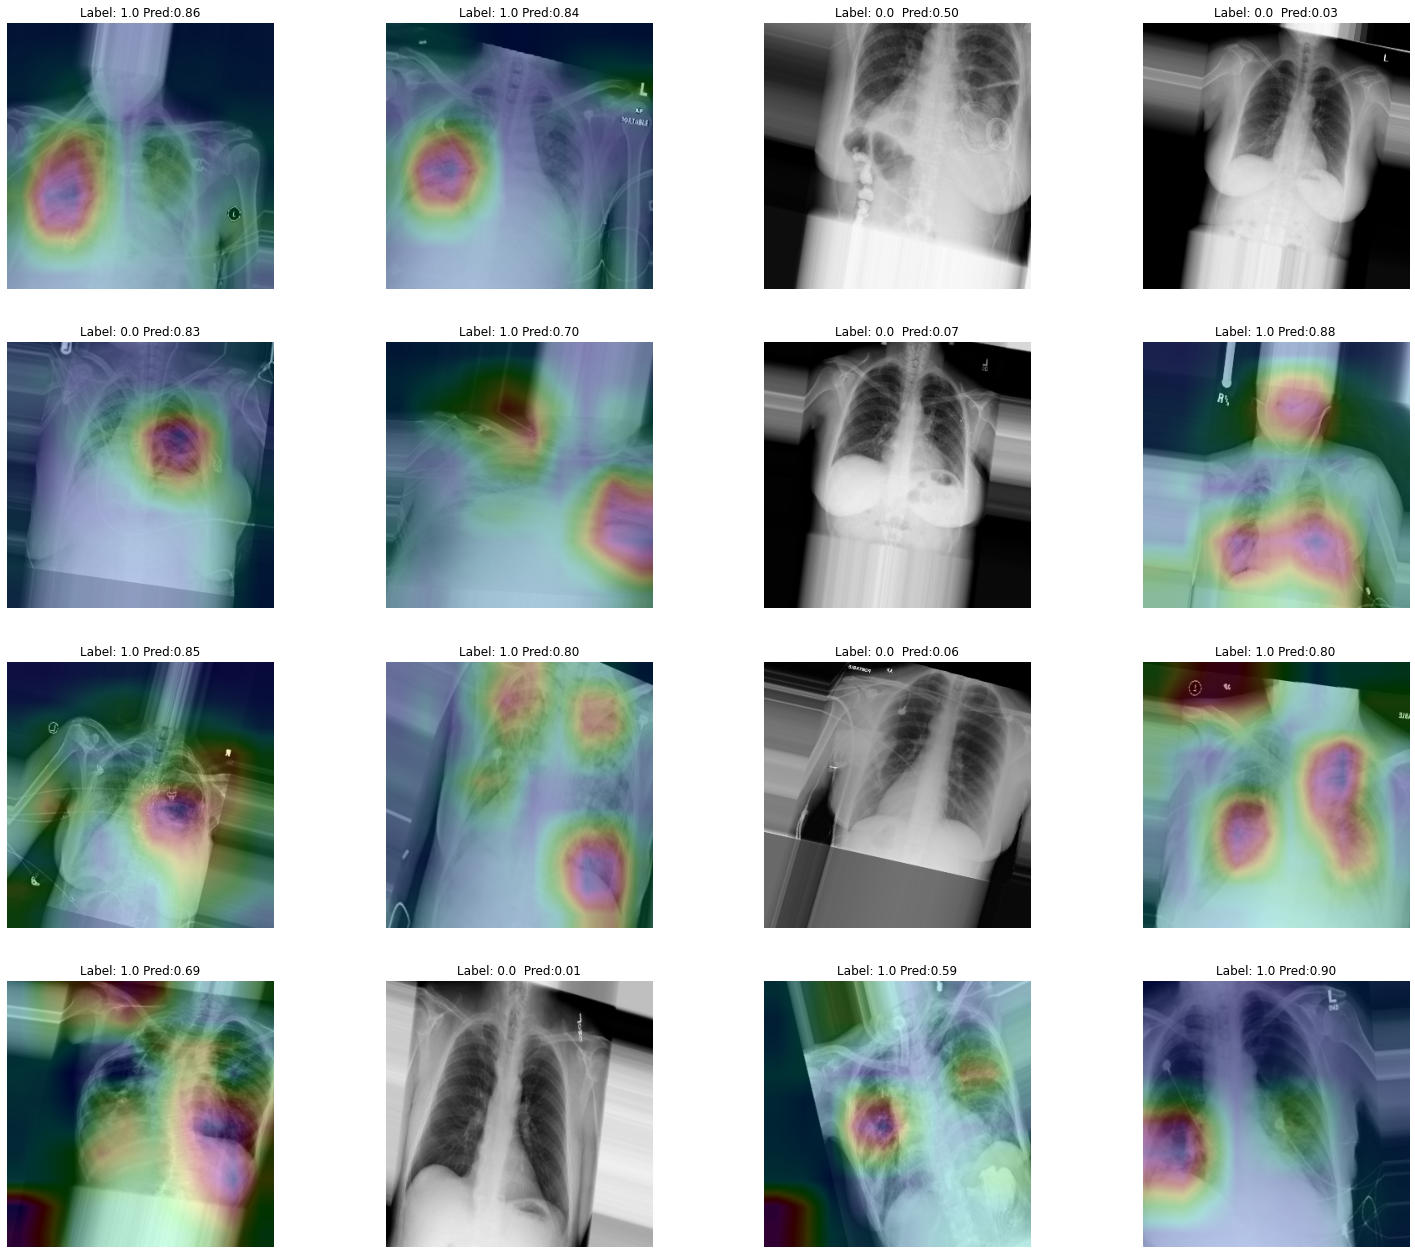

In [25]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf


fig = plt.figure(figsize=(26,46))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)

test_imgs,test_labels = next(val_generator)
# print(test_labels.shape, test_imgs.shape)
preds = chexnet_model.predict(test_imgs)
y_pred = np.where(preds>0.5, 1, 0)
# print(preds.shape, preds)
for cnt in np.arange(16) : #test_labels.shape[0]):
  # print(test_imgs[cnt].shape)
  test_img = test_imgs[cnt]
  #print("Ground Truth:",test_labels[cnt], " Prediction:", y_pred[cnt])
  ax = fig.add_subplot(8, 4, cnt + 1)
  if (y_pred[cnt]>0):
      temp_img = (test_img * 255.).astype('uint8')
      cam = GradCAM(model=chexnet_model, classIdx=0, layerName=None)
      heatmap = cam.compute_heatmap(image=test_img, normalize=True)
      overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                          colormap=cv2.COLORMAP_HSV)
      ax.imshow(overlaid_heatmap)
      ax.axis('off')
      ax.set_title("Label: {} Pred:{:.2f}".format(test_labels[cnt], preds[cnt][0]))
      # plt.show()
  else:
      ax.imshow(test_imgs[cnt])
      ax.axis('off')
      ax.set_title("Label: {}  Pred:{:.2f}".format(test_labels[cnt], preds[cnt][0]))
      # plt.show()


**Try after Segmenting the CXR to prevent the network from recognizing areas outside the lung region.**

In [ ]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Input, concatenate
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF


In [ ]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
segmentor.summary()
segmentor.load_weights('/content/drive/My Drive/cxr_reg_weights.hdf5')

In [ ]:
def do_segmentation(images, disk_rad=40, kernel_size=(5, 5), num_iter=3, margin=0):
    equ_images = [rank.equalize(image.squeeze(), selem=disk(radius=disk_rad)) for image in images]
    masks = [segmentor(np.expand_dims(equ_image, axis=[0, -1])) for equ_image in equ_images]
    masks = [cv2.dilate(np.squeeze(mask), kernel=np.ones(kernel_size), iterations=num_iter) for mask in masks]
    images = [image[np.min(np.where(masks[idx]==1)[0]) - margin:np.max(np.where(masks[idx]==1)[0]) + margin, 
                    np.min(np.where(masks[idx]==1)[1]) - margin:np.max(np.where(masks[idx]==1)[1]) + margin]
              for idx, image in enumerate(images)]
    images = [cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in images]
    images = [np.expand_dims(image, axis=-1) for image in images]
    return np.array(images)

In [ ]:
%%time
X_segmented = do_segmentation(images=X)

In [ ]:
X = X_segmented[:3628]
y = y[:3628]

num_covid_samples = 0
num_normal_samples = 0
for idx, img in enumerate(X):
  if y[idx]:
    num_covid_samples += 1
  else:
    num_normal_samples += 1
print('num carious images:', num_covid_samples)
print('num healthy images:', num_normal_samples)


# manual label smoothing by 0.1 deviation
# y[np.where(y == 0)] = 0.1
# y[np.where(y == 1)] = 0.9

# apply image enhancements and concat with the original image
X_beasf = np.array([BEASF(image=image, gamma=1.5) for image in X])
X_clahe = np.array([cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image) for image in X])
X_clahe = np.array([np.expand_dims(a=image, axis=-1) for image in X_clahe])
X = np.concatenate((X_beasf, X_clahe, X), axis=-1)

X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# # NOTE: sklearn train_test_split function copies the dataset, hence deleting initial data
# # variables will increase RAM space drastically (~ x2)
del X, X_segmented, y

**Steps Performed:**
1. Resnet50 with pre-trained imagenet weights
2. Removed Top Classification Layer
3. Locked Base Model layers to prevent training
4. Added own classification layers with the final output layer using Sigmoid activation.

**Iteration 1**
1. Image Data Augmenter with no manipulation 
2. Used Adam with lr=1e-4
3. 15 epochs, batch size=32
4. Got about 82% accuracy - DID NOT STORE RESULTS

**Iteration 2**
1. Image Data Augmenter with no manipulation 
2. Used SGD with lr=1e-4
3. 160 epochs, , batch size=32
4. Got > 80% accuracy - captured wts and history (history: history.csv, wts:lung_opacity_weights.best.hdf5)

**Iteration 3**
1. Image Data Augmenter with manipulation 
2. Used SGD with lr=1e-4
3. Continued from previous wts - 15 epochs, , batch size=128
4. Got > 80% accuracy - captured wts and history (history: history2-data-aug.csv, wts:lung_opacity_weights.aug.best.hdf5)

**Iteration 4**
1. Image Data Augmenter with manipulation 
2. Used ADAM with lr=1e-4
3. Continued from previous wts - 15 epochs, , batch size=128
4. Got > 80% accuracy - captured wts and history (history: history3-data-aug-adam.csv, wts:lung_opacity_weights.aug-adam.best.hdf5)
5. Noticed Overfitting



**Unlock last two layers of Base Model**

The first few convolutional layers of CNN capture high level features of the given image including lines, curves etc. The last few layers capture finer details.

With this understanding we will try to unlock and retrain the last two convolutional layers along with the classification layer.



**Iteration 1**
1. Unlocked last two convolutional blocks for training
2. Adam Optimizer with lr = 1e-4
3. Dropout = 0.25
4. 10 epochs (Runtime de-allocated after 6 iterations)
5. Noticed Overfitting train acc=86% val acc=81%

**Iteration 2**
1. Increased Dropout to 0.5 to handle overfitting
2. Training accuracy >99% validation ~80% - SEVERE OVERFITTING
3. Model was not learning - memorizing
4. LOST THESE WTS and HISTORY since they were inadvartently overwritten.


**Challenges**

1. Validation accuracy was almost constant at ~81% while training accuracy increased upto 99%

**Realization**

Unfreezing pretrained blocks and training with random wts on the classifier layer was messing up the gradients.

**We need to train the final classifier layer first and save those wts before unfreezing and training.**

**Iteration 1**
1. Started with an accuracy of 81% which quickly got upto > 97% but validation accuracy was still stuck close to 81%

**Iteration 2**
1. Modify optimizer to SGD + momentum
2. Training ended at 4th epoch since validation loss was not decreasing.
3. Did not see marked improvement in train/val accuracy
4. However, there was not overfitting.

**After several attempts, performance did not seem to improve, so we simplified the classifier layer.**
**Back to Square One**

**Iteration 1**
1. Training just the classifier for 10 epochs with adam optimizer, dropout=0.25.
2. Validation Loss plateued at about 6 epochs.
3. Training accuracy kept increasing while validation accuracy kept constant. Network was memorizing rather than generalizing/learning.
4. Final train acc = 84%, val acc > 81%

**Iteration 2**
1. Increasing dropout to 0.4
2. Data Augmentation
3. Train Accuracy 84.3%, val acc = 81.37
4. Looks like a good enough fit at the moment.


**Iteration 3**
1. Added l2 regularization to the dense layer

**After several iterations and tweaks, the best I could get to was 81% validation accuracy. Give up!**

**Unlocked the last two blocks - starting layer 81**
**Iteration 1**
1. Severe overfitting seen from 3rd epoch

**L2 Regularized pre-trained layers for Resnet50**
**Iteration 1**


**After 3 days of head butting**
Found https://github.com/keras-team/keras/issues/9214#issuecomment-397916155 that says that problem is the way BatchNormalization is implemented in keras. 

To understand why this happens we need to understand how the BN works. When the network is in training mode, the mini-batch statistics of BN are used for training the network; when the network is in inference mode, we use the moving mean/var learned during the training. That's all good. The problem is how the layer behaves when it is frozen. Its side-effects are more profound when we use fine-tuning and Transfer Learning.

You see, when frozen and while in training mode the BN continues to use the mini-batch statistics for scaling the training data. This causes the unfrozen/trainable layers to adapt to the scale of the data. Unfortunately during inference mode (predictions) the network will switch to the moving mean/var. If the moving mean/var is different that the mini-batch statistics the data are scaled differently causing massive discrepancies on the accuracy. If you want more info, have a look at the PR.

**Weird Issue - Validation Accuracy converged/maxed out at 77.47% while losses decreased, despite changes to the network topology, hyper parameters, image augmentation etc.**




Adam, Image Aug, BN /content/drive/My Drive/Colab Notebooks/Capstone Project/model/train_history_onlyfc_do-25-ds-128-batch-8-adam-l1reg-lr1e2-balance-origsize-fc-3-1.csv


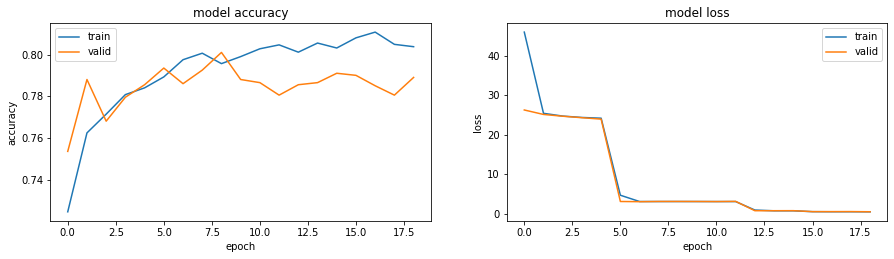

In [ ]:
# Plot Iteration 2
base_drive_path = "/content/drive/My Drive/Colab Notebooks/Capstone Project/model/"
histories = {
             "Adam, Image Aug, BN": "train_history_onlyfc_do-25-ds-128-batch-8-adam-l1reg-lr1e2-balance-origsize-fc-3-1.csv"
             }

for key, value in histories.items():
  plot_training_graphs(key, base_drive_path+value)